In [177]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import skew, kurtosis
from scipy.stats import chi2_contingency


%matplotlib inline

In [2]:
df_final_demo = pd.read_csv('df_final_demo.txt')
df_final_experiment_clients = pd.read_csv('df_final_experiment_clients.txt')
df_pt_1 = pd.read_csv('df_pt_1.txt')
df_pt_2 = pd.read_csv('df_pt_2.txt')

- Unir las dos partes de pt.

In [7]:
df_pt = pd.concat([df_pt_1, df_pt_2], ignore_index=True)

- Verificar valores nulos.

In [15]:
df_final_demo.isnull().sum()

client_id            0
clnt_tenure_yr      14
clnt_tenure_mnth    14
clnt_age            15
gendr               14
num_accts           14
bal                 14
calls_6_mnth        14
logons_6_mnth       14
dtype: int64

In [16]:
df_final_experiment_clients.isnull().sum()

client_id        0
Variation    20109
dtype: int64

In [17]:
df_pt.isnull().sum()

client_id       0
visitor_id      0
visit_id        0
process_step    0
date_time       0
dtype: int64

#### Limpieza de datos

- Eliminación de valores nulos en df_final_demo, solo 14-15 filas de 70609

In [19]:
df_final_demo = df_final_demo.dropna()

- Detección de duplicados

In [21]:
duplicados_demo = df_final_demo.duplicated()
duplicados_experiment_clients = df_final_experiment_clients.duplicated()
duplicados_pt = df_pt.duplicated()

- Eliminación de duplicados en df_pt

In [26]:
df_pt = df_pt.drop_duplicates()

- No existe forma de detectar el variation a partir de los campos de las otras tablas, tenemos que hacer drop de nulos para tener la tabla limpia.

In [31]:
df_final_experiment_clients = df_final_experiment_clients.dropna()

- Nos quedamos solo con los registros que tengan un client_id común en las tres tablas (df_final_demo, df_final_experiment_clients y df_pt). Esto te permitirá unificar la información y trabajar con un conjunto de datos consistente.

- Función set.intersection() para encontrar los client_id que están presentes en las tres tablas.

In [33]:
# Identificar los client_id presentes en cada tabla
client_ids_demo = set(df_final_demo['client_id'])
client_ids_experiment = set(df_final_experiment_clients['client_id'])
client_ids_pt = set(df_pt['client_id'])

# Encontrar la intersección de los tres conjuntos
client_ids_comunes = client_ids_demo.intersection(client_ids_experiment).intersection(client_ids_pt)

# Verificar la cantidad de client_id comunes
print(f"Número de client_id comunes en las tres tablas: {len(client_ids_comunes)}")

Número de client_id comunes en las tres tablas: 50487


In [34]:
# Filtrar df_final_demo
df_final_demo= df_final_demo[df_final_demo['client_id'].isin(client_ids_comunes)]

# Filtrar df_final_experiment_clients
df_final_experiment_clients = df_final_experiment_clients[df_final_experiment_clients['client_id'].isin(client_ids_comunes)]

# Filtrar df_pt
df_pt= df_pt[df_pt['client_id'].isin(client_ids_comunes)]

# Verificar las dimensiones de las tablas filtradas
print(f"Dimensiones de df_final_demo: {df_final_demo.shape}")
print(f"Dimensiones de df_final_experiment_clients: {df_final_experiment_clients.shape}")
print(f"Dimensiones de df_pt: {df_pt.shape}")


Dimensiones de df_final_demo: (50487, 9)
Dimensiones de df_final_experiment_clients: (50487, 2)
Dimensiones de df_pt: (317123, 5)


- df_pt tiene más registros porque se representan ahí los pasos del experimento entonces se repiten los id para cada paso del mismo cliente.

- Conversión de tipos.

In [41]:
df_final_demo['clnt_tenure_yr'] = df_final_demo['clnt_tenure_yr'].astype(int)
df_final_demo['clnt_tenure_mnth'] = df_final_demo['clnt_tenure_mnth'].astype(int)
df_final_demo['num_accts'] = df_final_demo['num_accts'].astype(int)
df_final_demo['calls_6_mnth'] = df_final_demo['calls_6_mnth'].astype(int)
df_final_demo['logons_6_mnth'] = df_final_demo['logons_6_mnth'].astype(int)

- Conversión de la columna date_time de object a datetime.

In [43]:
df_pt['date_time'] = pd.to_datetime(df_pt['date_time'])

In [46]:
df_final = df_final_experiment_clients

- Renombrado de columnas.

In [47]:
df_pt = df_pt.rename(columns={'process_step': 'step'})

In [48]:
df_final_demo = df_final_demo.rename(columns={
    'clnt_tenure_yr': 'tenure_years',
    'clnt_tenure_mnth': 'tenure_months',
    'clnt_age': 'age',
    'gendr': 'gender',
    'num_accts': 'num_accounts',
    'bal': 'balance',
    'calls_6_mnth': 'calls_6_months',
    'logons_6_mnth': 'logons_6_months'
})

- Unión de df_final y df_final_demo

In [52]:
df_final = pd.merge(df_final, df_final_demo, on='client_id', how='inner')

In [54]:
df_final = df_final.rename(columns={'Variation': 'variation'})

- Determinar los clientes más importantes del df de acuerdo a factores como tenure, num_accounts, balance, calls_6_months y logons_6_months

- Sacamos la media de estas columnas y calculamos el percentil 90 para calcular a continuación el top 10% clientes.

In [56]:
# Calcular la media de cada columna.
mean_tenure = df_final['tenure_years'].mean()
mean_balance = df_final['balance'].mean()
mean_num_accounts = df_final['num_accounts'].mean()
mean_activity = (df_final['calls_6_months'] + df_final['logons_6_months']).mean()

In [57]:
# Calcular el percentil 90 de cada columna.
percentile_90_tenure = df_final['tenure_years'].quantile(0.90)
percentile_90_balance = df_final['balance'].quantile(0.90)
percentile_90_num_accounts = df_final['num_accounts'].quantile(0.90)
percentile_90_activity = (df_final['calls_6_months'] + df_final['logons_6_months']).quantile(0.90)

- Clientes por encima de la media.

In [58]:
df_above_mean = df_final[
    (df_final['tenure_years'] > mean_tenure) &
    (df_final['balance'] > mean_balance) &
    (df_final['num_accounts'] > mean_num_accounts) &
    ((df_final['calls_6_months'] + df_final['logons_6_months']) > mean_activity)
]

- Clientes top 10%

In [60]:
df_top_10 = df_final[
    (df_final['tenure_years'] >= percentile_90_tenure) &
    (df_final['balance'] >= percentile_90_balance) &
    (df_final['num_accounts'] >= percentile_90_num_accounts) &
    ((df_final['calls_6_months'] + df_final['logons_6_months']) >= percentile_90_activity)
]

- Creamos una nueva columna para indicar a qué grupo pertenece cada cliente, si está en el grupo 'general' o por encima de la media o es top 10%

- Asignamos el grupo 'Above Mean' solo a aquellos que no están en Top 10%

In [62]:
df_final['group'] = 'General'

df_final.loc[df_final['client_id'].isin(df_top_10['client_id']), 'group'] = 'Top 10%'

df_final.loc[
    (df_final['tenure_years'] > mean_tenure) &
    (df_final['balance'] > mean_balance) &
    (df_final['num_accounts'] > mean_num_accounts) &
    ((df_final['calls_6_months'] + df_final['logons_6_months']) > mean_activity) &
    (df_final['group'] == 'General'),
    'group'
] = 'Above Mean'


In [64]:
df_final['group'].value_counts()

group
General       48188
Above Mean     1875
Top 10%         424
Name: count, dtype: int64

- Visualización de la distribución de balance con un Boxplot.

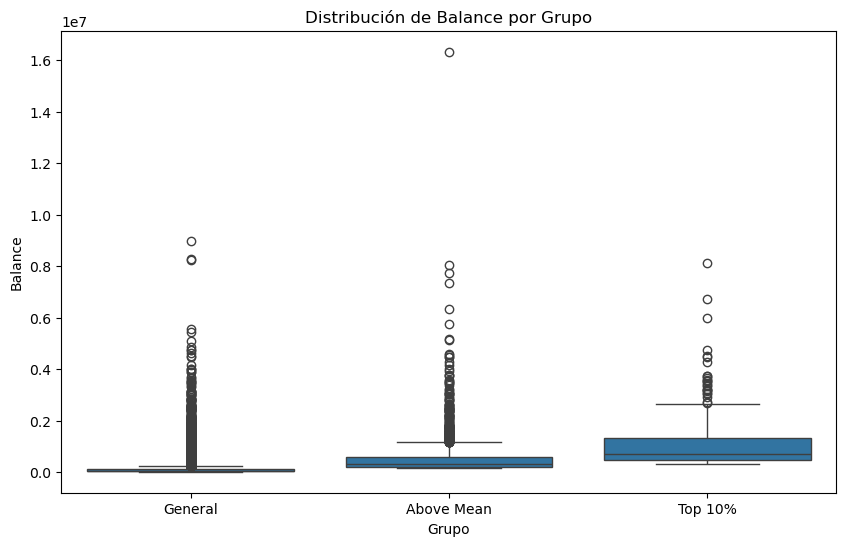

In [65]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='group', y='balance', data=df_final)
plt.title('Distribución de Balance por Grupo')
plt.xlabel('Grupo')
plt.ylabel('Balance')
plt.show()

- Visualización de la distribución de tenure_years con un Gráfico de Barras.

C:\Users\usr\AppData\Local\Temp\ipykernel_3712\1119270055.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='group', y='tenure_years', data=df_final, estimator='mean', ci=None)


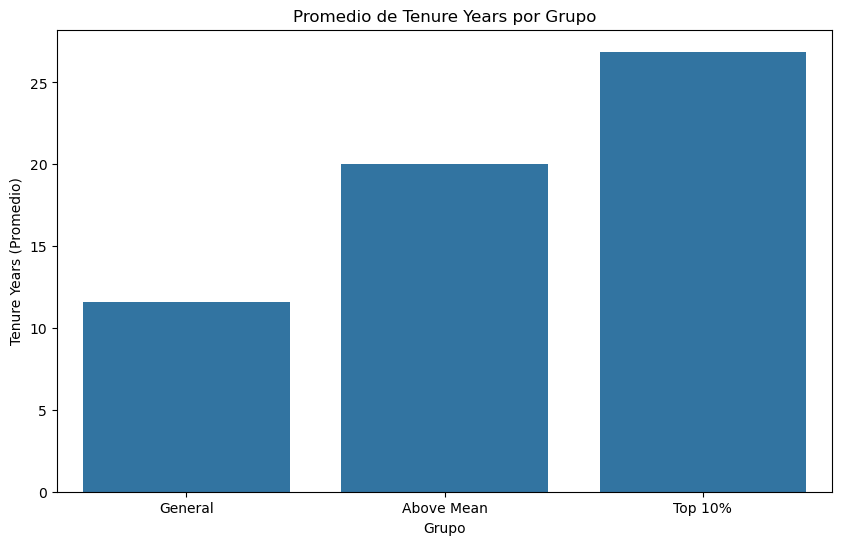

In [66]:
plt.figure(figsize=(10, 6))
sns.barplot(x='group', y='tenure_years', data=df_final, estimator='mean', ci=None)
plt.title('Promedio de Tenure Years por Grupo')
plt.xlabel('Grupo')
plt.ylabel('Tenure Years (Promedio)')
plt.show()

- Boxplot de la distribución de tenure_years por grupo.

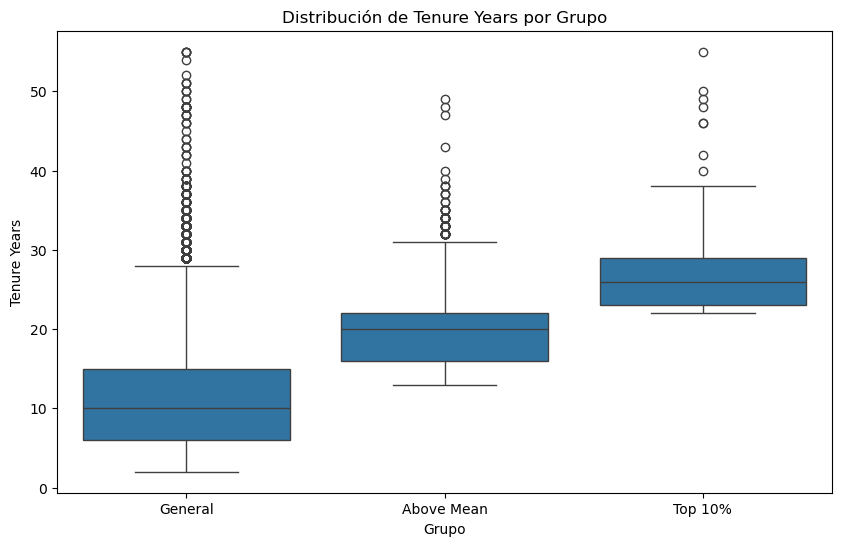

In [67]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='group', y='tenure_years', data=df_final)
plt.title('Distribución de Tenure Years por Grupo')
plt.xlabel('Grupo')
plt.ylabel('Tenure Years')
plt.show()

- Visualización de la actividad reciente (suma de calls_6_months y logons_6_months) con un Boxplot.

- Creamos una columna para la actividad reciente.

In [68]:
df_final['activity'] = df_final['calls_6_months'] + df_final['logons_6_months']

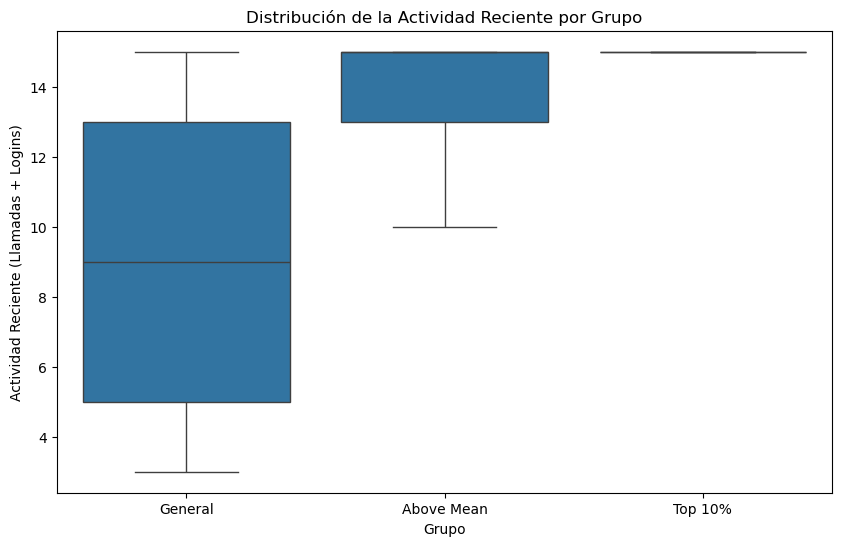

In [69]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='group', y='activity', data=df_final)
plt.title('Distribución de la Actividad Reciente por Grupo')
plt.xlabel('Grupo')
plt.ylabel('Actividad Reciente (Llamadas + Logins)')
plt.show()

- Visualización del número de cuentas (num_accounts) por grupo con un Gráfico de Barras.

C:\Users\usr\AppData\Local\Temp\ipykernel_3712\644004275.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='group', y='num_accounts', data=df_final, estimator='mean', ci=None)


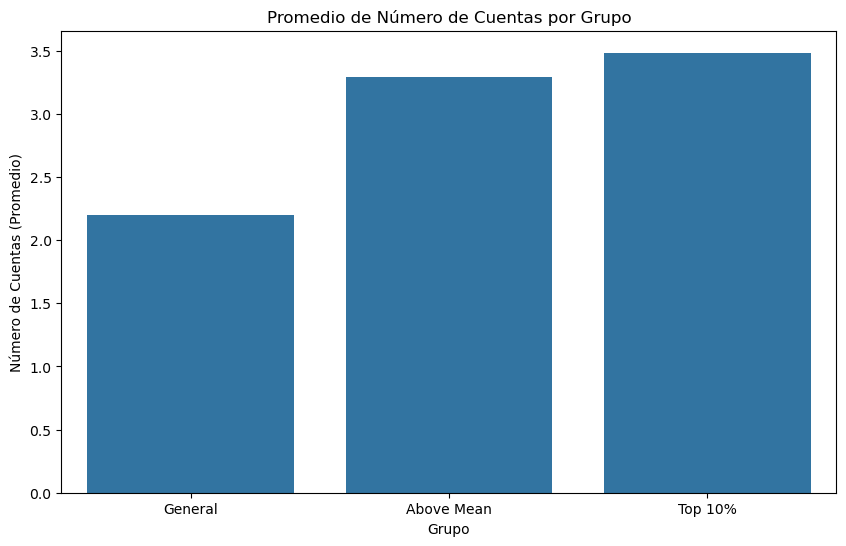

In [70]:
plt.figure(figsize=(10, 6))
sns.barplot(x='group', y='num_accounts', data=df_final, estimator='mean', ci=None)
plt.title('Promedio de Número de Cuentas por Grupo')
plt.xlabel('Grupo')
plt.ylabel('Número de Cuentas (Promedio)')
plt.show()

- Scatter plot de balance vs. tenure_years

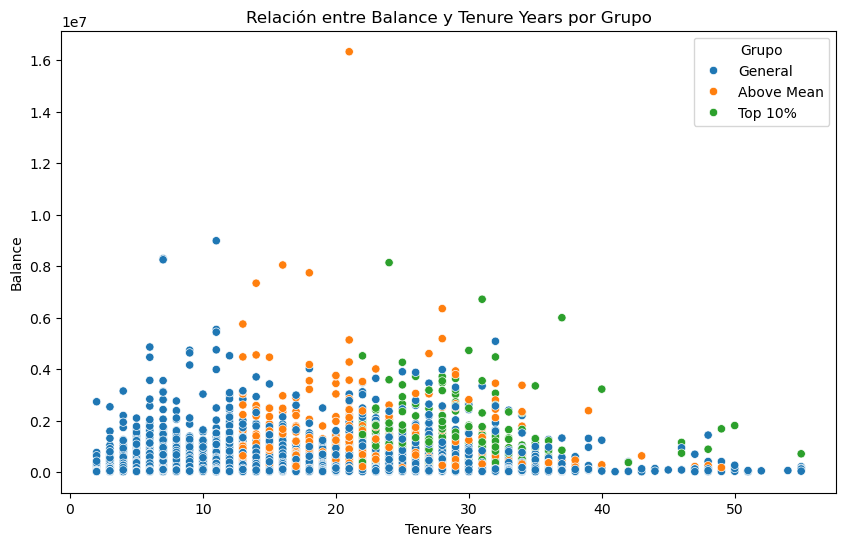

In [71]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tenure_years', y='balance', hue='group', data=df_final)
plt.title('Relación entre Balance y Tenure Years por Grupo')
plt.xlabel('Tenure Years')
plt.ylabel('Balance')
plt.legend(title='Grupo')
plt.show()

- Boxplot de la distribución de la edad por grupo.

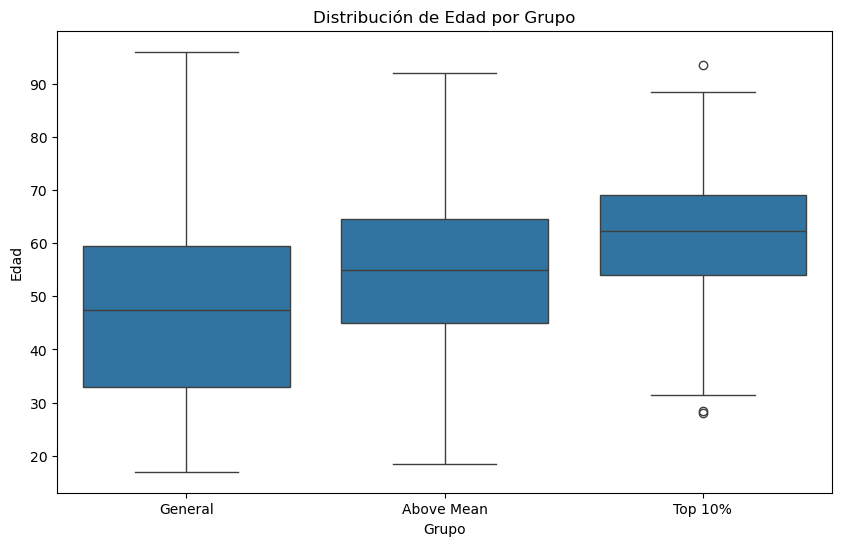

In [72]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='group', y='age', data=df_final)
plt.title('Distribución de Edad por Grupo')
plt.xlabel('Grupo')
plt.ylabel('Edad')
plt.show()

- Promedio de la edad por grupo.

In [73]:
mean_age_by_group = df_final.groupby('group')['age'].mean()
mean_age_by_group

group
Above Mean    54.536800
General       46.911181
Top 10%       61.844340
Name: age, dtype: float64

- Visualización del promedio de edad por grupo

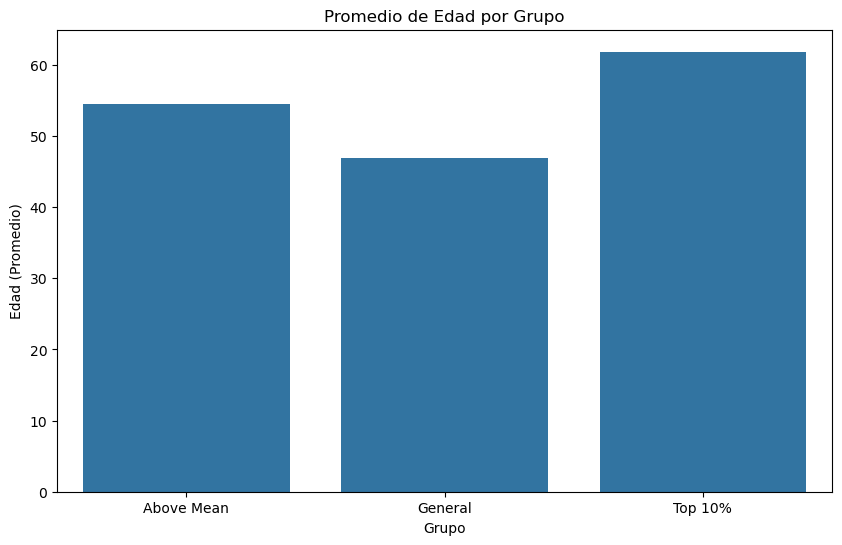

In [74]:
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_age_by_group.index, y=mean_age_by_group.values)
plt.title('Promedio de Edad por Grupo')
plt.xlabel('Grupo')
plt.ylabel('Edad (Promedio)')
plt.show()

- Nueva columna para la clasificación de edad.

In [75]:
df_final['age_group'] = pd.cut(df_final['age'], bins=[0, 35, 55, 100], labels=['Young', 'Middle-aged', 'Senior'])

In [76]:
df_final['age_group'].value_counts()

age_group
Middle-aged    18486
Senior         17673
Young          14328
Name: count, dtype: int64

- Distribución de clientes por grupo de edad y grupo general.

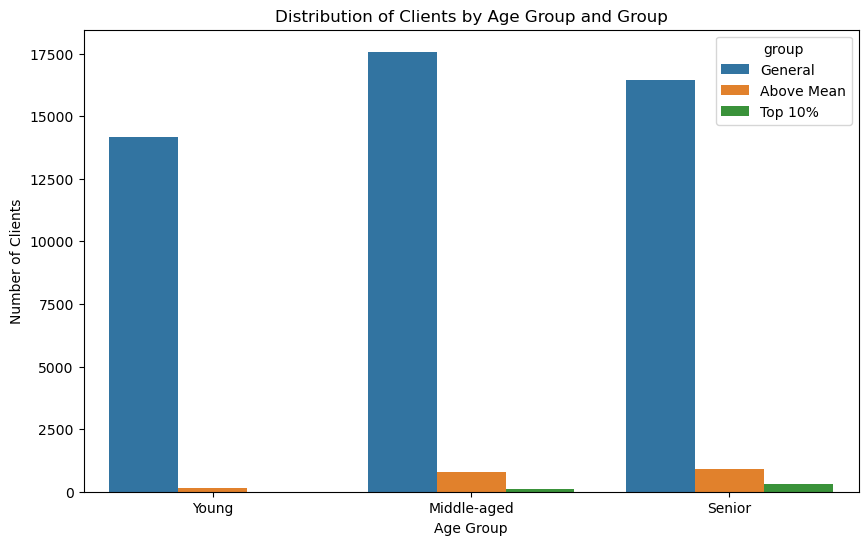

In [77]:
plt.figure(figsize=(10, 6))
sns.countplot(x='age_group', hue='group', data=df_final)
plt.title('Distribution of Clients by Age Group and Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Clients')
plt.show()

- Promedio de balance por grupo de edad y grupo general.

C:\Users\usr\AppData\Local\Temp\ipykernel_3712\1389795894.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='age_group', y='balance', hue='group', data=df_final, estimator='mean', ci=None)


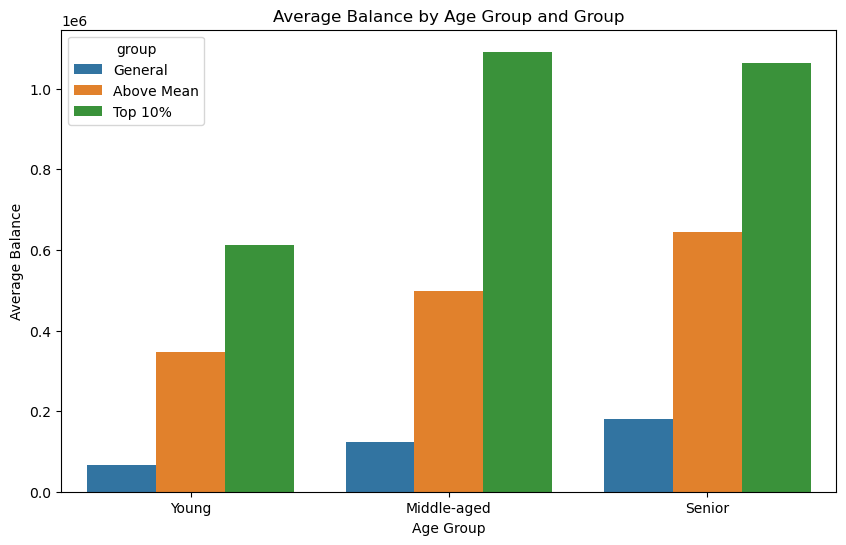

In [78]:
plt.figure(figsize=(10, 6))
sns.barplot(x='age_group', y='balance', hue='group', data=df_final, estimator='mean', ci=None)
plt.title('Average Balance by Age Group and Group')
plt.xlabel('Age Group')
plt.ylabel('Average Balance')
plt.show()

- Promedio de tenure years por grupo de edad y grupo general.

C:\Users\usr\AppData\Local\Temp\ipykernel_3712\1346673204.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='age_group', y='tenure_years', hue='group', data=df_final, estimator='mean', ci=None)


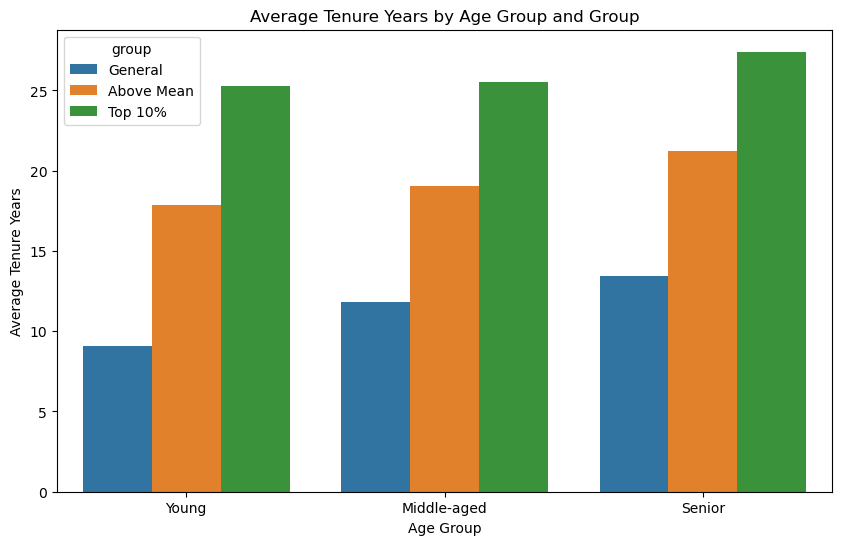

In [79]:
plt.figure(figsize=(10, 6))
sns.barplot(x='age_group', y='tenure_years', hue='group', data=df_final, estimator='mean', ci=None)
plt.title('Average Tenure Years by Age Group and Group')
plt.xlabel('Age Group')
plt.ylabel('Average Tenure Years')
plt.show()

- Actividad reciente por grupo de edad y grupo general.

C:\Users\usr\AppData\Local\Temp\ipykernel_3712\1704854293.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='age_group', y='activity', hue='group', data=df_final, estimator='mean', ci=None)


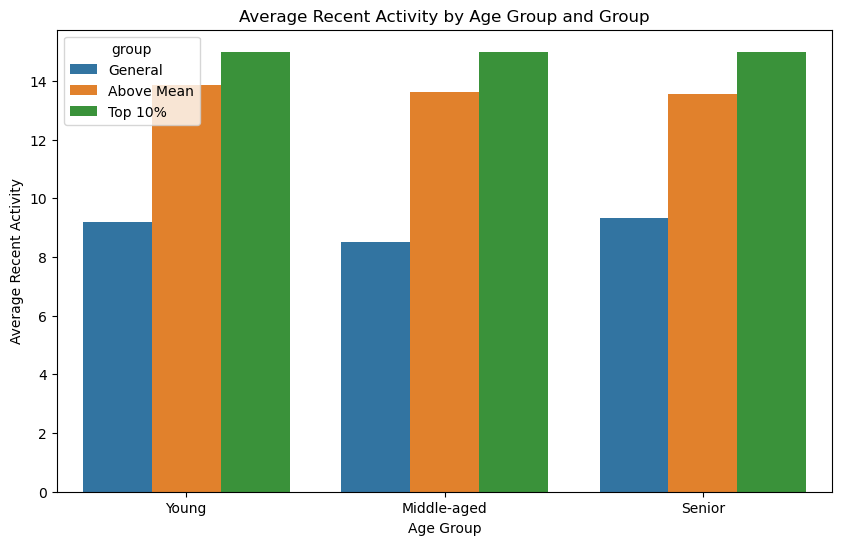

In [80]:
plt.figure(figsize=(10, 6))
sns.barplot(x='age_group', y='activity', hue='group', data=df_final, estimator='mean', ci=None)
plt.title('Average Recent Activity by Age Group and Group')
plt.xlabel('Age Group')
plt.ylabel('Average Recent Activity')
plt.show()

- Crosstab para observar la relación entre las categorías de grupos de clientes y grupos de edad, comparación de variables categóricas.

In [81]:
crosstab_age_group = pd.crosstab(df_final['age_group'], df_final['group'], normalize='index')

In [82]:
crosstab_age_group

group,Above Mean,General,Top 10%
age_group,,,
Young,0.011097,0.988624,0.000279
Middle-aged,0.043006,0.950719,0.006275
Senior,0.052113,0.930685,0.017201


- Visualización con un heatmap para ver las proporciones.

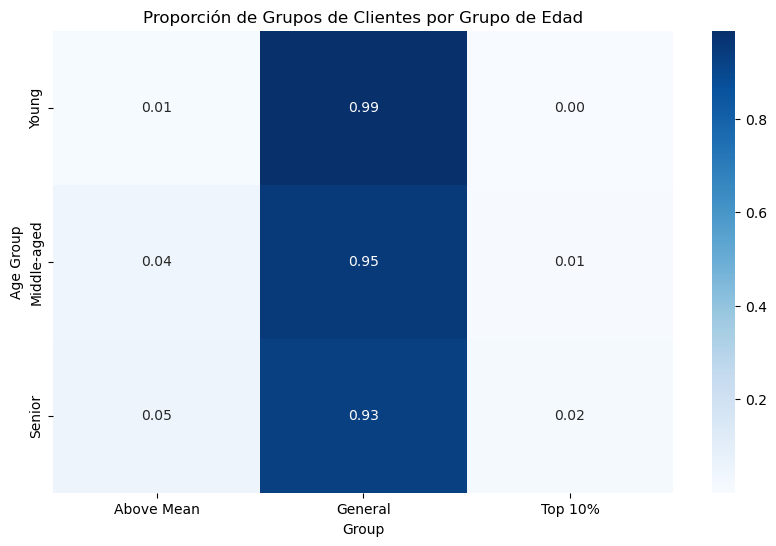

In [83]:
plt.figure(figsize=(10, 6))
sns.heatmap(crosstab_age_group, annot=True, cmap='Blues', fmt='.2f')
plt.title('Proporción de Grupos de Clientes por Grupo de Edad')
plt.xlabel('Group')
plt.ylabel('Age Group')
plt.show()

- Distribución sesgada, hay muy pocos clientes en Above Mean y Top 10% comparado con el General Group.

- Hacemos Plotchart para visualizar mejor.
- Crosstab sin normalizar para contar simplemente las frecuencias brutas y ver mejor la representación.

In [84]:
crosstab_age_group_raw = pd.crosstab(df_final['age_group'], df_final['group'])

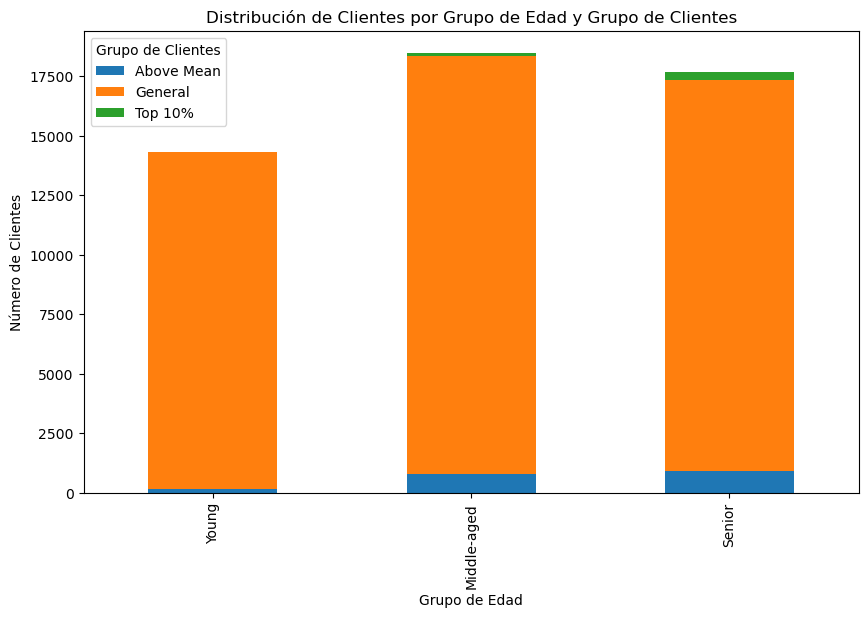

In [85]:
crosstab_age_group_raw.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Distribución de Clientes por Grupo de Edad y Grupo de Clientes')
plt.xlabel('Grupo de Edad')
plt.ylabel('Número de Clientes')
plt.legend(title='Grupo de Clientes')
plt.show()

- Crosstab y Plotbar para ver las proporciones dentro de cada grupo de clientes.

In [86]:
crosstab_group_age_prop = pd.crosstab(df_final['group'], df_final['age_group'], normalize='index')

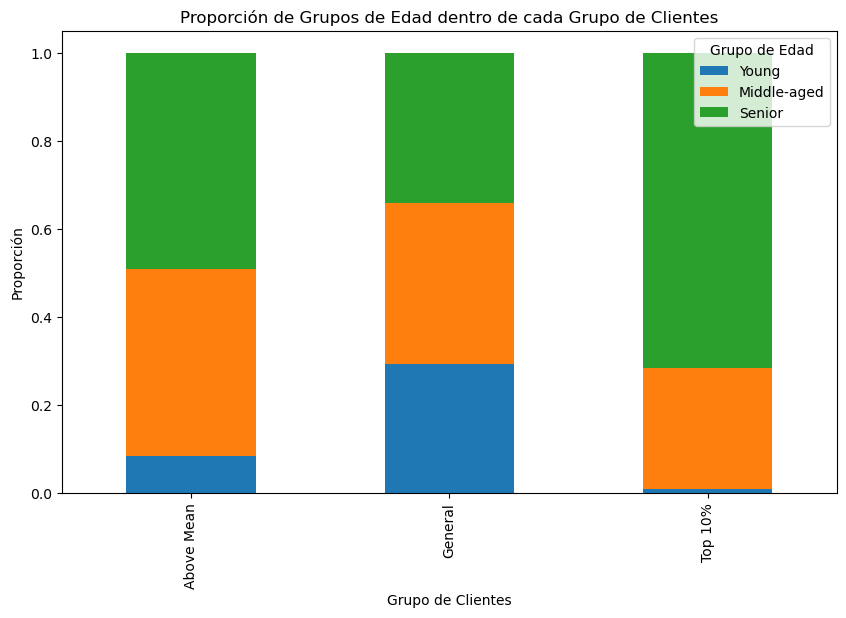

In [87]:
crosstab_group_age_prop.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Proporción de Grupos de Edad dentro de cada Grupo de Clientes')
plt.xlabel('Grupo de Clientes')
plt.ylabel('Proporción')
plt.legend(title='Grupo de Edad')
plt.show()

- Análisis por separado de los grupos 'Above Mean' y 'Top 10%'

In [88]:
df_above_mean = df_final[df_final['group'] == 'Above Mean']
df_top_10 = df_final[df_final['group'] == 'Top 10%']

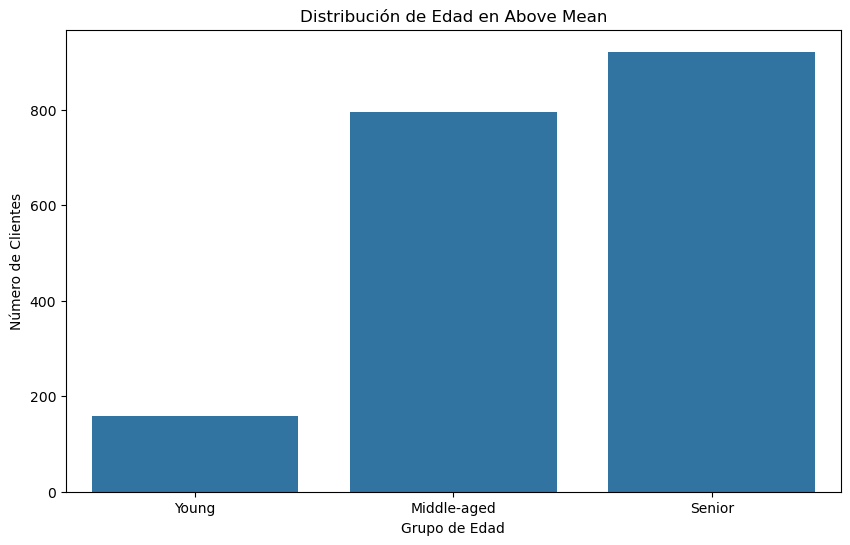

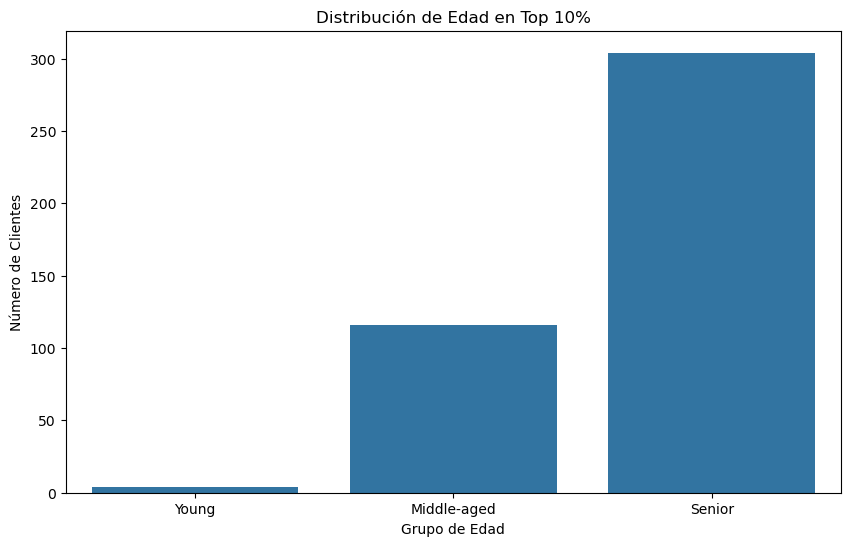

In [89]:
plt.figure(figsize=(10, 6))
sns.countplot(x='age_group', data=df_above_mean)
plt.title('Distribución de Edad en Above Mean')
plt.xlabel('Grupo de Edad')
plt.ylabel('Número de Clientes')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='age_group', data=df_top_10)
plt.title('Distribución de Edad en Top 10%')
plt.xlabel('Grupo de Edad')
plt.ylabel('Número de Clientes')
plt.show()

- Crosstab de group vs num_accounts -> ¿Los clientes en el Top 10% tienden a tener más cuentas con la empresa en comparación con el resto?

In [90]:
crosstab_group_accounts = pd.crosstab(df_final['group'], df_final['num_accounts'])
crosstab_group_accounts

num_accounts,1,2,3,4,5,6,7
group,,,,,,,
Above Mean,0,0,1406,392,68,9,0
General,1,39720,7276,1070,110,7,4
Top 10%,0,0,265,123,27,7,2


- Plotbar de group vs num_accounts

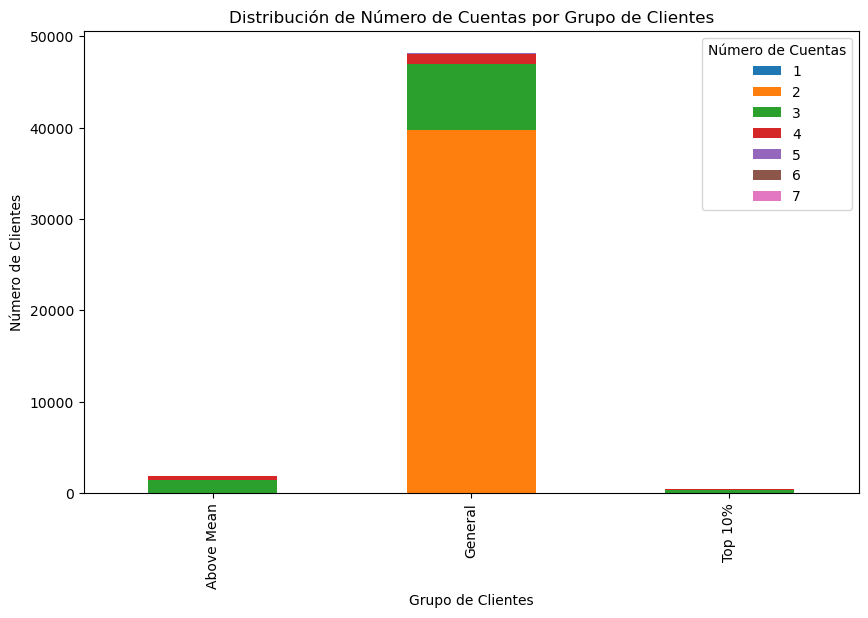

In [91]:
crosstab_group_accounts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Distribución de Número de Cuentas por Grupo de Clientes')
plt.xlabel('Grupo de Clientes')
plt.ylabel('Número de Clientes')
plt.legend(title='Número de Cuentas')
plt.show()

- Crosstab de age_group vs. balance -> ¿Los clientes más jóvenes (Young) tienden a tener balances más bajos en comparación con los clientes mayores (Senior)?

In [92]:
# Clasificar el balance en categorías
df_final['balance_category'] = pd.qcut(df_final['balance'], q=3, labels=['Low', 'Medium', 'High'])

In [93]:
crosstab_age_balance = pd.crosstab(df_final['age_group'], df_final['balance_category'])
crosstab_age_balance

balance_category,Low,Medium,High
age_group,,,
Young,7026,5379,1923
Middle-aged,5732,6376,6378
Senior,4071,5074,8528


- Heatmap de age_group vs. balance

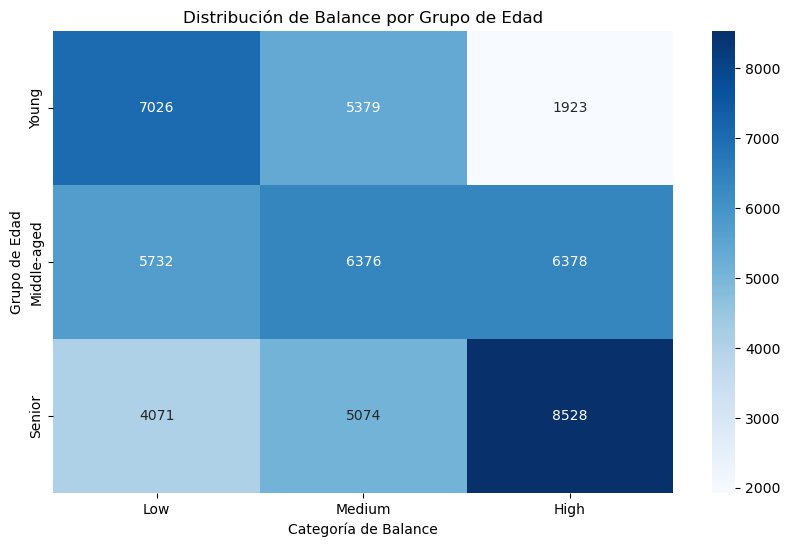

In [94]:
plt.figure(figsize=(10, 6))
sns.heatmap(crosstab_age_balance, annot=True, cmap='Blues', fmt='d')
plt.title('Distribución de Balance por Grupo de Edad')
plt.xlabel('Categoría de Balance')
plt.ylabel('Grupo de Edad')
plt.show()

- Crosstab de group vs. activity -> ¿Los clientes en el Top 10% muestran una mayor actividad reciente en comparación con los otros grupos?

In [95]:
# Clasificar la actividad en categorías
df_final['activity_category'] = pd.qcut(df_final['activity'], q=3, labels=['Low', 'Medium', 'High'])

In [96]:
crosstab_group_activity = pd.crosstab(df_final['group'], df_final['activity_category'])
crosstab_group_activity

activity_category,Low,Medium,High
group,,,
Above Mean,0,872,1003
General,22513,14777,10898
Top 10%,0,0,424


- Plotbar de group vs. activity

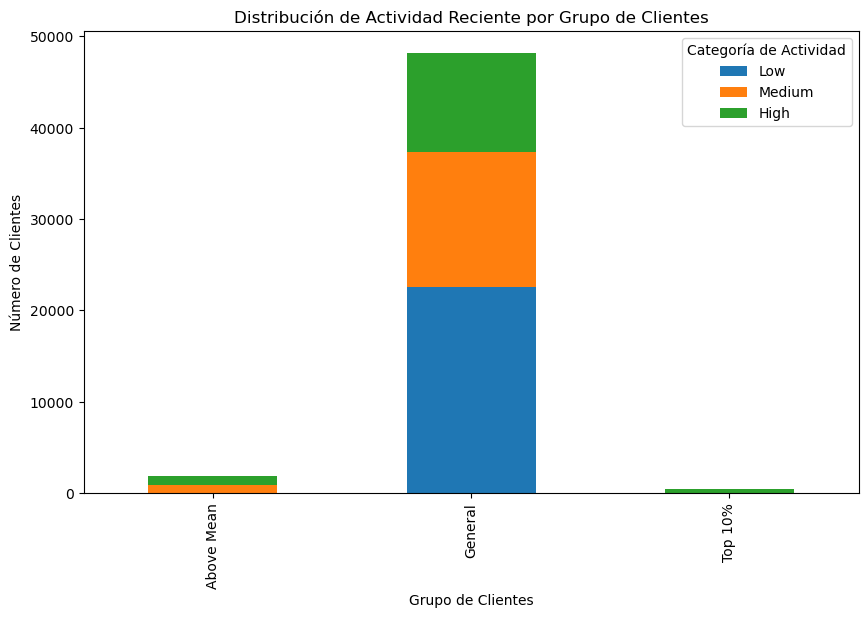

In [97]:
crosstab_group_activity.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Distribución de Actividad Reciente por Grupo de Clientes')
plt.xlabel('Grupo de Clientes')
plt.ylabel('Número de Clientes')
plt.legend(title='Categoría de Actividad')
plt.show()

- Crosstab de group vs. gender -> ¿Hay una distribución de género que favorezca a un grupo particular de clientes? Por ejemplo, ¿son más hombres o mujeres los que están en el Top 10%?

In [98]:
crosstab_group_gender = pd.crosstab(df_final['group'], df_final['gender'])
crosstab_group_gender

gender,F,M,U,X
group,,,,
Above Mean,564,1218,93,0
General,15590,15420,17176,2
Top 10%,104,309,11,0


- Plotbar de group vs. gender

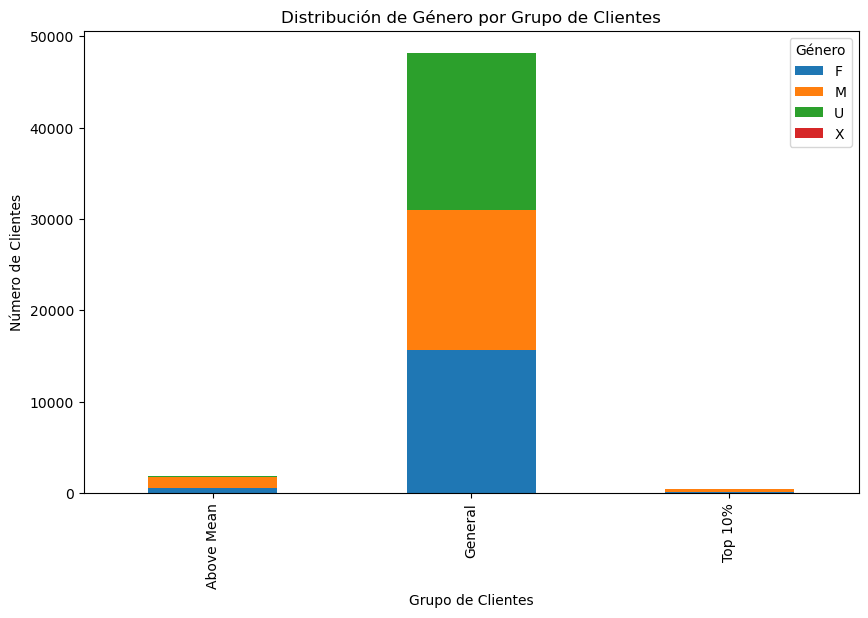

In [99]:
crosstab_group_gender.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Distribución de Género por Grupo de Clientes')
plt.xlabel('Grupo de Clientes')
plt.ylabel('Número de Clientes')
plt.legend(title='Género')
plt.show()

- Crosstab de group vs. tenure_years -> ¿Los clientes con mayor antigüedad (por ejemplo, más de 20 años) tienden a estar más representados en el Top 10%?

In [100]:
# Clasificar tenure_years en categorías
df_final['tenure_category'] = pd.cut(df_final['tenure_years'], bins=[0, 5, 10, 20, 50], labels=['0-5', '6-10', '11-20', '21+'])

In [101]:
crosstab_group_tenure = pd.crosstab(df_final['group'], df_final['tenure_category'])
crosstab_group_tenure

tenure_category,0-5,6-10,11-20,21+
group,,,,
Above Mean,0,0,1027,848
General,8729,15975,17792,5683
Top 10%,0,0,0,423


- Heatmap de group vs. tenure_years

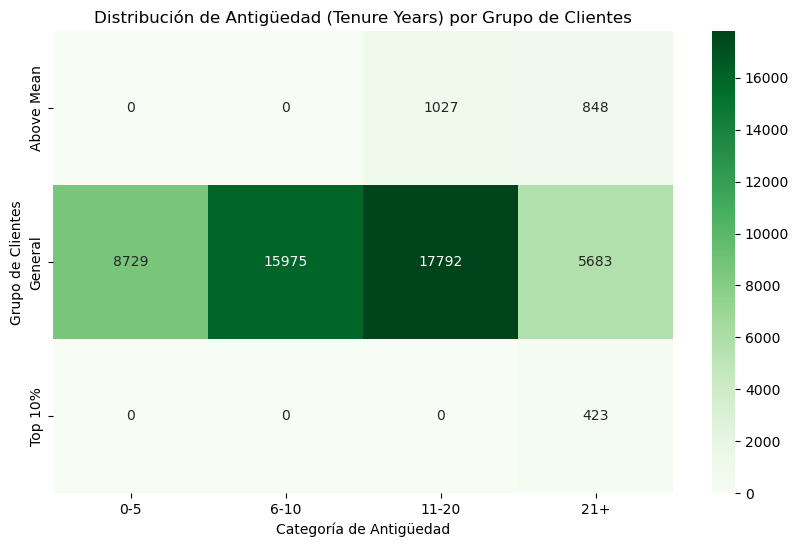

In [102]:
plt.figure(figsize=(10, 6))
sns.heatmap(crosstab_group_tenure, annot=True, cmap='Greens', fmt='d')
plt.title('Distribución de Antigüedad (Tenure Years) por Grupo de Clientes')
plt.xlabel('Categoría de Antigüedad')
plt.ylabel('Grupo de Clientes')
plt.show()

- Skewness: Mide la asimetría de la distribución de datos. Indica si los datos están sesgados hacia la derecha (skewness positiva) o hacia la izquierda (skewness negativa).
    - Positivo: Indica que la cola derecha es más larga, con una mayor concentración de valores en el lado izquierdo.
    - Negativo: Indica que la cola izquierda es más larga, con una mayor concentración de valores en el lado derecho.
    - Cerca de 0: Indica una distribución aproximadamente simétrica.

- Kurtosis: Mide la "apuntalamiento" de la distribución, es decir, cuán concentrados están los valores en los extremos de la distribución. Una kurtosis alta indica una distribución con colas largas (muchos valores extremos).
    - Mayor que 3: Indica que la distribución tiene colas más pesadas o extremas que una distribución normal.
    - Menor que 3: Indica una distribución más plana con colas menos extremas.
    - Igual a 3: Es lo esperado para una distribución normal.

- Skewness y kurtosis para balance

In [103]:
balance_skewness = skew(df_final['balance'])
balance_kurtosis = kurtosis(df_final['balance'])

print(f"Skewness de Balance: {balance_skewness}")
print(f"Kurtosis de Balance: {balance_kurtosis}")

Skewness de Balance: 11.473735597799463
Kurtosis de Balance: 294.08323027965804


- Skewness y kurtosis para tenure_years

In [104]:
tenure_skewness = skew(df_final['tenure_years'])
tenure_kurtosis = kurtosis(df_final['tenure_years'])

print(f"Skewness de Tenure Years: {tenure_skewness}")
print(f"Kurtosis de Tenure Years: {tenure_kurtosis}")

Skewness de Tenure Years: 1.0317572387170437
Kurtosis de Tenure Years: 1.0176829517477666


- Skewness y kurtosis para activity

In [105]:
activity_skewness = skew(df_final['activity'])
activity_kurtosis = kurtosis(df_final['activity'])

print(f"Skewness de Activity: {activity_skewness}")
print(f"Kurtosis de Activity: {activity_kurtosis}")

Skewness de Activity: 0.041087214888499965
Kurtosis de Activity: -1.4340583081769527


- Histogramas con curvas de densidad: ver si la distribución está sesgada (asimetría) y si tiene colas largas o cortas (curtosis).

- Para balance

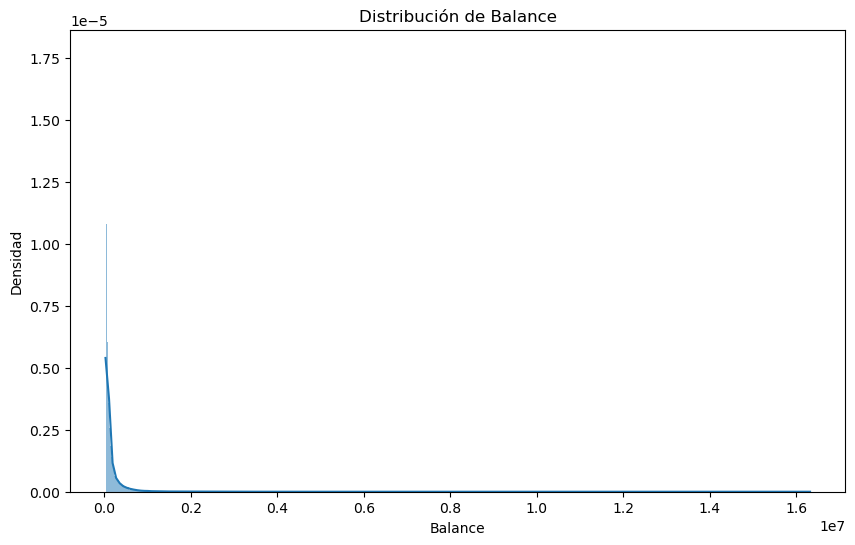

In [106]:
plt.figure(figsize=(10, 6))
sns.histplot(df_final['balance'], kde=True, stat="density", linewidth=0)
plt.title('Distribución de Balance')
plt.xlabel('Balance')
plt.ylabel('Densidad')
plt.show()

-  Para tenure_years

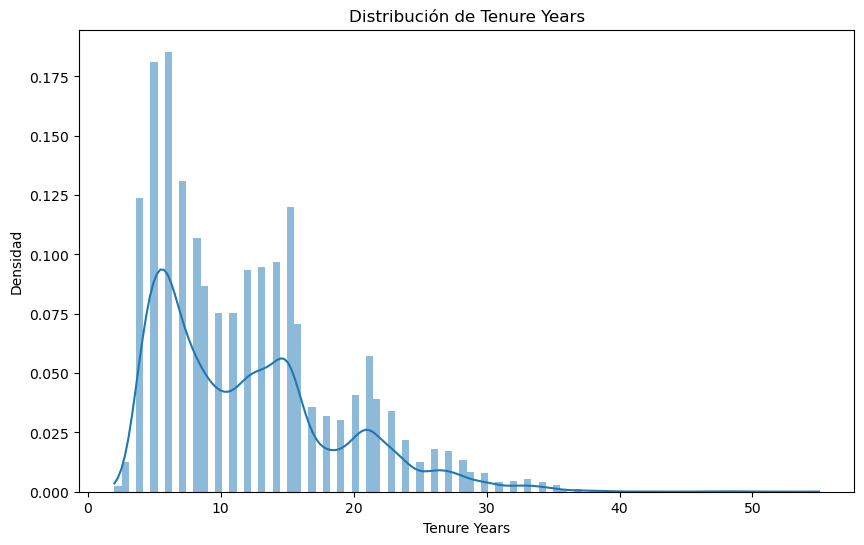

In [107]:
plt.figure(figsize=(10, 6))
sns.histplot(df_final['tenure_years'], kde=True, stat="density", linewidth=0)
plt.title('Distribución de Tenure Years')
plt.xlabel('Tenure Years')
plt.ylabel('Densidad')
plt.show()

- Para activity

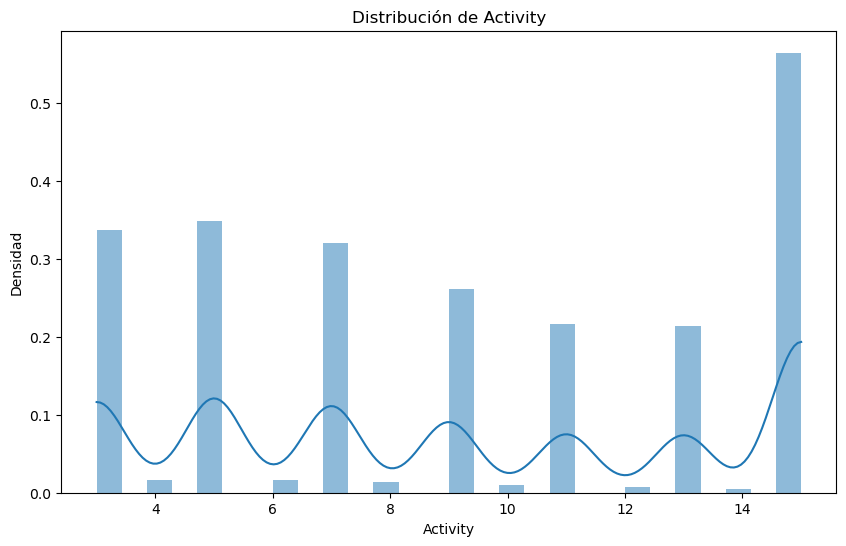

In [108]:
plt.figure(figsize=(10, 6))
sns.histplot(df_final['activity'], kde=True, stat="density", linewidth=0)
plt.title('Distribución de Activity')
plt.xlabel('Activity')
plt.ylabel('Densidad')
plt.show()

- Q-Q Plots (Quantile-Quantile Plots)
    - Comparan la distribución de nuestros datos con una distribución normal. Si los puntos se desvían significativamente de la línea recta, esto indica skewness o kurtosis.

- Para balance

<Figure size 1000x600 with 0 Axes>

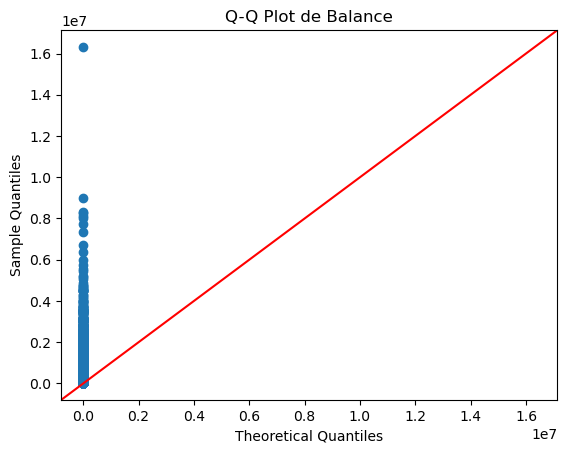

In [109]:
plt.figure(figsize=(10, 6))
sm.qqplot(df_final['balance'], line ='45')
plt.title('Q-Q Plot de Balance')
plt.show()

- Para tenure_years

<Figure size 1000x600 with 0 Axes>

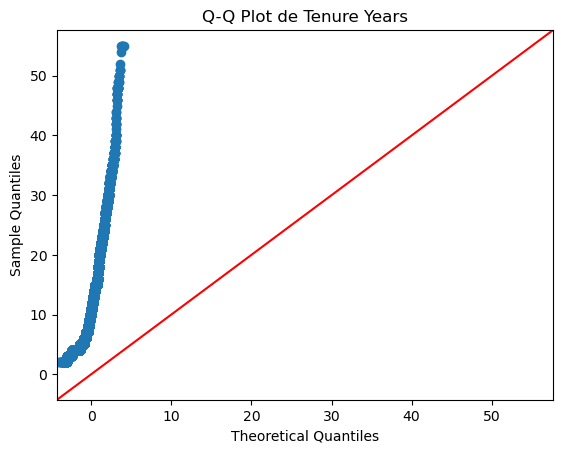

In [110]:
plt.figure(figsize=(10, 6))
sm.qqplot(df_final['tenure_years'], line ='45')
plt.title('Q-Q Plot de Tenure Years')
plt.show()

- Para activity

<Figure size 1000x600 with 0 Axes>

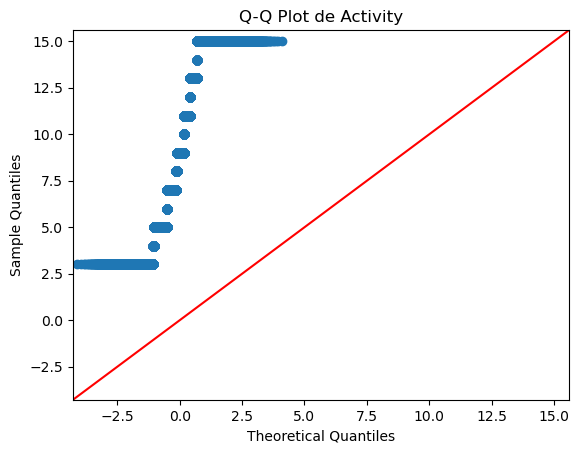

In [111]:
plt.figure(figsize=(10, 6))
sm.qqplot(df_final['activity'], line ='45')
plt.title('Q-Q Plot de Activity')
plt.show()

- Boxplots
    - Ver la skewness visualmente a través de la distribución de los datos en cuartiles, y también para identificar posibles outliers (que pueden contribuir a una alta kurtosis).
    - Datos sesgados (si la mediana no está centrada) y si hay outliers que podrían estar afectando la curtosis.

- Para balance

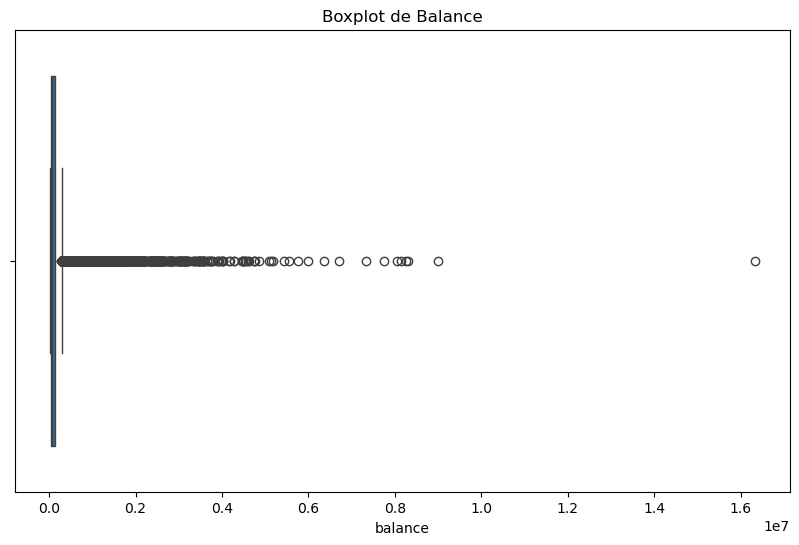

In [112]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_final['balance'])
plt.title('Boxplot de Balance')
plt.show()

- Para tenure_years

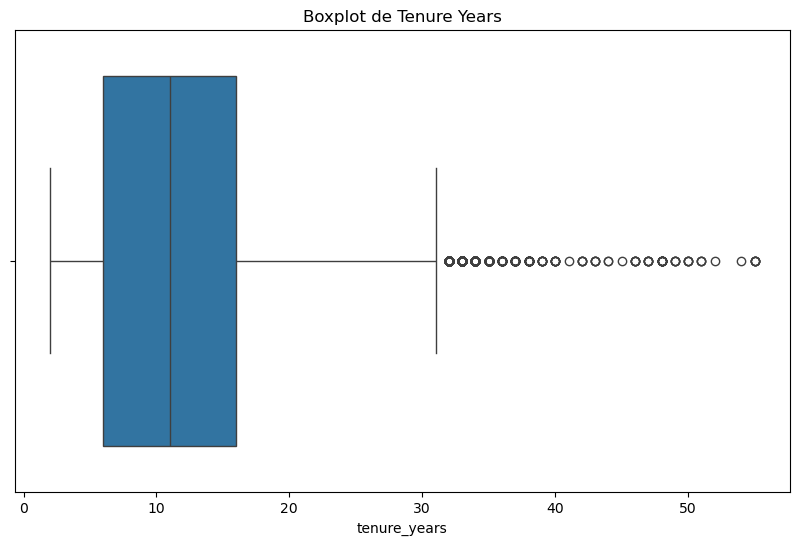

In [113]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_final['tenure_years'])
plt.title('Boxplot de Tenure Years')
plt.show()

- Para activity

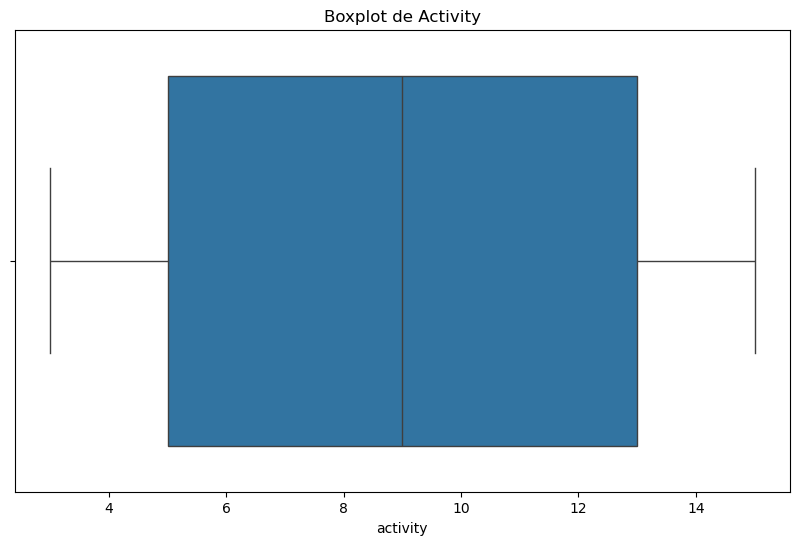

In [114]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_final['activity'])
plt.title('Boxplot de Activity')
plt.show()

- KDE Plots (Kernel Density Estimation)
    - Muestra la estimación de la densidad de probabilidad de una variable. Es especialmente útil para visualizar la skewness.
    - Forma general de la distribución, incluidas las colas largas.

- Para balance

C:\Users\usr\AppData\Local\Temp\ipykernel_3712\3334209554.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_final['balance'], shade=True)


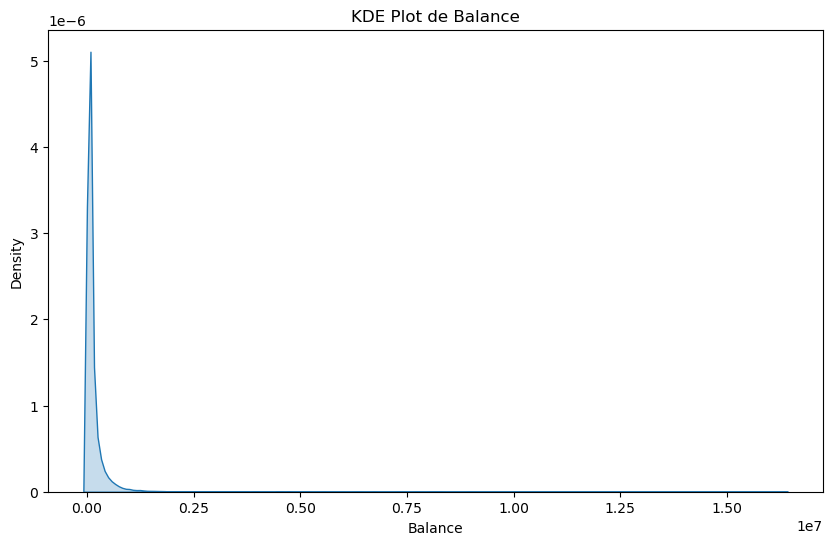

In [115]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df_final['balance'], shade=True)
plt.title('KDE Plot de Balance')
plt.xlabel('Balance')
plt.show()

- Para tenure_years

C:\Users\usr\AppData\Local\Temp\ipykernel_3712\1409489100.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_final['tenure_years'], shade=True)


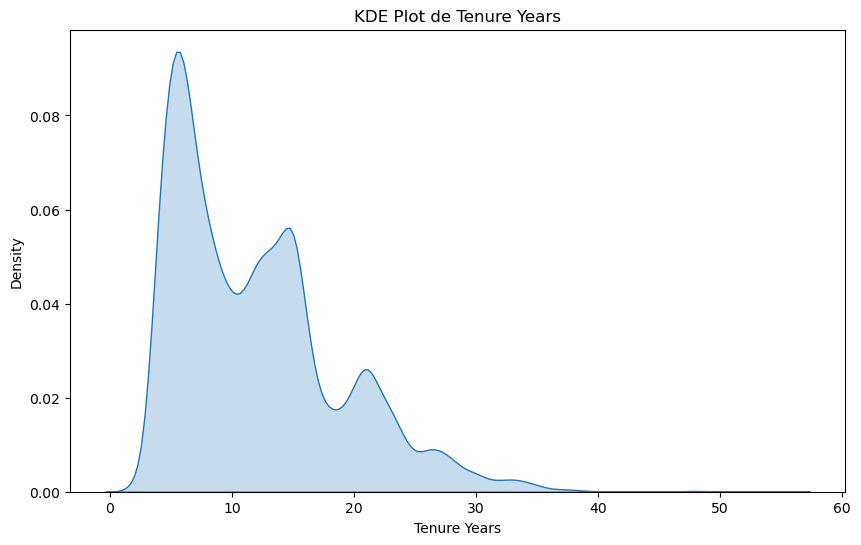

In [116]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df_final['tenure_years'], shade=True)
plt.title('KDE Plot de Tenure Years')
plt.xlabel('Tenure Years')
plt.show()

- Para activity

C:\Users\usr\AppData\Local\Temp\ipykernel_3712\2726040404.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_final['activity'], shade=True)


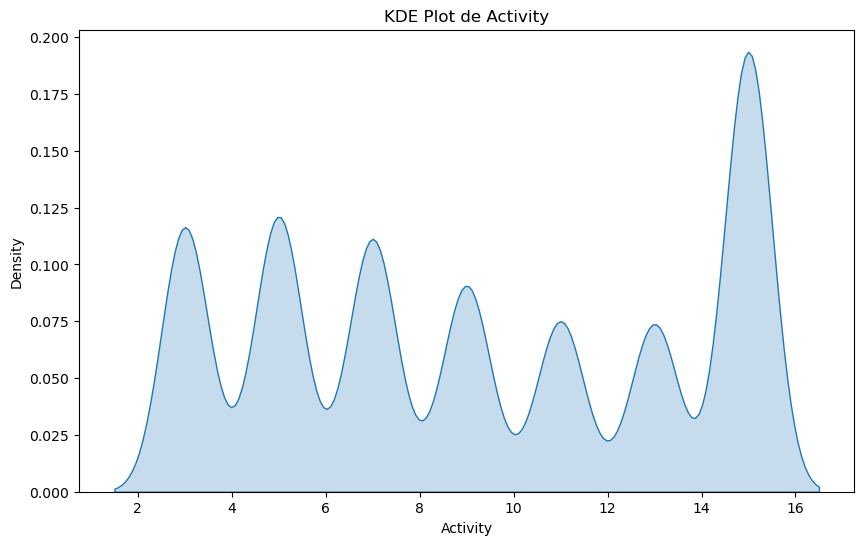

In [117]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df_final['activity'], shade=True)
plt.title('KDE Plot de Activity')
plt.xlabel('Activity')
plt.show()

In [118]:
df_final

,client_id,variation,tenure_years,tenure_months,age,gender,num_accounts,balance,calls_6_months,logons_6_months,group,activity,age_group,balance_category,activity_category,tenure_category
0,9988021,Test,5,64,79.0,U,2,189023.86,1,4,General,5,Senior,High,Low,0-5
1,8320017,Test,22,274,34.5,M,2,36001.90,5,8,General,13,Young,Low,Medium,21+
2,4033851,Control,12,149,63.5,M,2,142642.26,5,8,General,13,Senior,High,Medium,11-20
3,1982004,Test,6,80,44.5,U,2,30231.76,1,4,General,5,Middle-aged,Low,Low,6-10
4,9294070,Control,5,70,29.0,U,2,34254.54,0,3,General,3,Young,Low,Low,0-5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50482,393005,Control,15,191,52.5,M,2,60344.67,1,4,General,5,Middle-aged,Medium,Low,11-20
50483,2908510,Control,21,252,34.0,M,3,141808.05,6,9,General,15,Young,High,High,21+
50484,7230446,Test,6,74,62.0,M,2,58778.11,2,5,General,7,Senior,Medium,Low,6-10
50485,5230357,Test,23,278,30.5,M,2,61349.70,0,3,General,3,Young,Medium,Low,21+


In [119]:
df_pt

,client_id,visitor_id,visit_id,step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04
...,...,...,...,...,...
637487,1574008,117364417_77840596075,528720790_71583064618_169151,start,2017-05-06 23:43:27
637532,2908510,814969699_90652851448,562606085_36368381773_92090,start,2017-05-10 22:57:17
637533,2908510,814969699_90652851448,562606085_36368381773_92090,step_2,2017-05-10 22:56:31
637534,2908510,814969699_90652851448,562606085_36368381773_92090,step_1,2017-05-10 22:56:23


#### Análisis de df_pt: calcular diferencias entre pasos consecutivos, tasa de abandono por paso, comportamiento por segmento de clientes, análisis por secuencias lineales y no lineales.

- Ordenar por client_id, visit_id, y date_time para asegurar que los pasos están en orden cronológico.

In [120]:
df_pt = df_pt.sort_values(by=['client_id', 'visit_id', 'date_time'])

- Asignamos un valor numérico a cada step para facilitar el análisis.

In [121]:
step_order = {'start': 1, 'step_1': 2, 'step_2': 3, 'step_3': 4, 'confirm': 5}
df_pt['step_order'] = df_pt['step'].map(step_order)

- step_diff es una columna que calculamos para medir la diferencia entre los valores numéricos asignados a los pasos (step_order) en una secuencia.
- Nos dirá si el cliente ha avanzado linealmente o no.

- Con groupby agrupamos los datos por client_id y visit_id, lo que significa que para cada cliente y para cada visita (sesión) calcularemos estas diferencias de pasos de forma independiente. Lo hacemos porque los clientes y sus visitas tienen diferentes secuencias de pasos.

- diff() calcula la diferencia entre valores consecutivos en la columna step_order dentro de cada grupo definido por client_id y visit_id
- Si un cliente sigue los pasos en orden entonces las diferencias serán 1 (2-1, 3-2, 4-3).
- Si un cliente retrocede de step entonces la diferencia será -1 (2-3).
- fillna(0) hace que los valores nulos, que aparecen de calcular la diferencia de start con el anterior (que no existe), sean 0, así evitamos errores ya que no podemos considerar eso como cliente que no sigue los pasos linealmente.

- non-linear será la columna que nos indique si la secuencia en ese punto es no-lineal, es decir, que step_diff sea negativo, y por lo tanto el cliente está retrocediendo en los pasos.
- lambda x: x< 0 es una función lambda aplicada a cada valor de step_diff si es negativo entonces non_linear es True, sino False

In [122]:
df_pt['step_diff'] = df_pt.groupby(['client_id', 'visit_id'])['step_order'].diff().fillna(0)
df_pt['non_linear'] = df_pt['step_diff'].apply(lambda x: x < 0)

- Ahora surge el problema de que existen clientes que repiten el paso varias veces.
- Contamos las veces que un cliente repite un paso específico.
- Medir el tiempo acumulado no solo en pasos únicos sino incluyendo todas las repeticiones.

In [124]:
# Contamos cuántas veces un cliente repite un paso en una misma visita
df_pt['step_repeat_count'] = df_pt.groupby(['client_id', 'visit_id', 'step']).cumcount() + 1

In [125]:
# Calculamos la diferencia de tiempo entre eventos dentro de la misma visita
df_pt['time_diff'] = df_pt.groupby(['client_id', 'visit_id'])['date_time'].diff()

# Rellenamos los valores NaN en time_diff con 0 para la primera aparición del paso.
df_pt['time_diff'] = df_pt['time_diff'].fillna(pd.Timedelta(seconds=0))

# Calculamos el tiempo total en cada paso, sumando time_diff dentro de cada paso y visita.
df_pt['total_time_in_step'] = df_pt.groupby(['client_id', 'visit_id', 'step_repeat_count'])['time_diff'].cumsum()

In [126]:
# Convertimos time_diff y total_time_in_step a segundos
df_pt['time_diff'] = df_pt['time_diff'].dt.total_seconds()
df_pt['total_time_in_step'] = df_pt['total_time_in_step'].dt.total_seconds()

- Ejemplos:
    - client_id: 934 tiene cuatro repeticiones del step 'start', lo cual se refleja en los valores 1, 2, 3, 4 en la columna 'step_repeat_count'.
    - client_id: 1028 repite el paso step_1 varias veces (hasta cinco veces), lo cual también está correctamente capturado.

- Analizar el tiempo en repeticiones para ver cuánto tiempo pasan los clientes en pasos repetidos y medir la gravedad del atasco.

- Definir condiciones para identificar un recorrido lineal

In [127]:
# Calculamos si hay más de dos repeticiones en cualquier paso.
max_repeats = df_pt.groupby(['client_id', 'visit_id'])['step_repeat_count'].max() <= 2

# Comprobamops si hay retrocesos (step_diff == -1)
no_retrocessions = ~(df_pt.groupby(['client_id', 'visit_id'])['step_diff'].apply(lambda x: (x == -1).any()))

# Aseguramos que los pasos se sigan en orden, con hasta una repetición permitida, y que el último paso sea confirm
def follows_correct_sequence_with_repeats(group):
    steps = group['step_order'].tolist()
    correct_sequence = [1, 2, 3, 4, 5]
    
    # Permitimos hasta una repetición de cada paso
    valid_steps = []
    for step in correct_sequence:
        count = steps.count(step)
        if count == 0:
            return False  # Falla si falta un paso
        valid_steps.extend([step] * min(count, 2))  # Permitimos hasta una repetición
    
    # Verificamos que los pasos en valid_steps estén en el orden correcto
    return steps == valid_steps

correct_order = df_pt.groupby(['client_id', 'visit_id']).apply(follows_correct_sequence_with_repeats)

# Unimos las tres condiciones
is_lineal = max_repeats & no_retrocessions & correct_order

# Propagamos los resultados de vuelta al DataFrame original
df_pt = df_pt.merge(is_lineal.rename('lineal'), on=['client_id', 'visit_id'])

C:\Users\usr\AppData\Local\Temp\ipykernel_3712\1433115245.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correct_order = df_pt.groupby(['client_id', 'visit_id']).apply(follows_correct_sequence_with_repeats)


In [131]:
# Filtramos clientes que completaron el proceso de manera lineal
lineal_true = df_pt[df_pt['lineal'] == True]

# Filtramos clientes que no completaron el proceso de manera lineal (errores)
lineal_false = df_pt[df_pt['lineal'] == False]

# Calculamos la tasa de finalización para los que completaron el proceso de manera lineal
completion_rate_lineal_true = lineal_true.groupby('variation')['client_id'].nunique() / df_pt.groupby('variation')['client_id'].nunique()

# Calculamos la tasa de "no finalización" para los que no completaron el proceso de manera lineal
completion_rate_lineal_false = lineal_false.groupby('variation')['client_id'].nunique() / df_pt.groupby('variation')['client_id'].nunique()

# Mostrar los resultados
print("Tasa de finalización (lineal=True):")
print(completion_rate_lineal_true)

print("\nTasa de no finalización (lineal=False):")
print(completion_rate_lineal_false)

Tasa de finalización (lineal=True):
variation
Control    0.460554
Test       0.474649
Name: client_id, dtype: float64

Tasa de no finalización (lineal=False):
variation
Control    0.651917
Test       0.642929
Name: client_id, dtype: float64


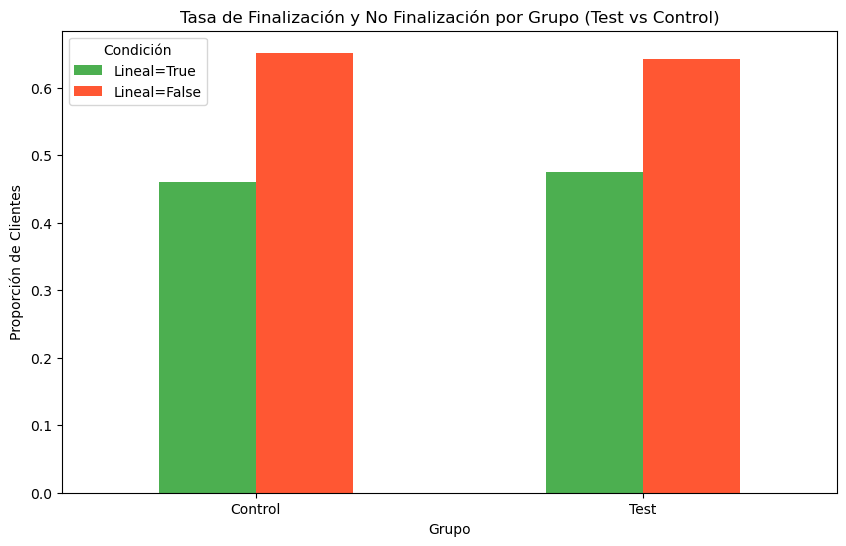

In [132]:
completion_rates = pd.DataFrame({
    'Lineal=True': completion_rate_lineal_true,
    'Lineal=False': completion_rate_lineal_false
})

completion_rates.plot(kind='bar', figsize=(10, 6), color=['#4CAF50', '#FF5733'])

plt.title('Tasa de Finalización y No Finalización por Grupo (Test vs Control)')
plt.xlabel('Grupo')
plt.ylabel('Proporción de Clientes')
plt.xticks(rotation=0)
plt.legend(title='Condición')

- Tiempo empleado en cada paso

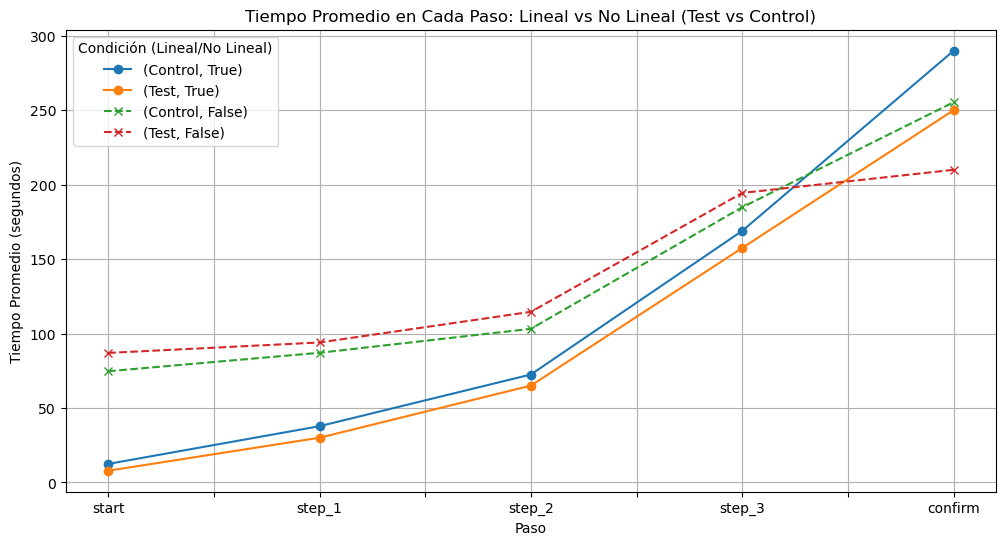

In [148]:
# Calcular el tiempo total promedio en cada paso por tipo de web (Test/Control) y por si el cliente fue lineal o no
avg_time_in_step_lineal = df_pt.groupby(['variation', 'lineal', 'step'])['total_time_in_step'].mean().unstack()

# Definimos el orden correcto de los pasos
step_order = ['start', 'step_1', 'step_2', 'step_3', 'confirm']

# Reordenamos las columnas en avg_time_in_step_lineal para reflejar el orden correcto
avg_time_in_step_lineal = avg_time_in_step_lineal[step_order]

# Graficar comparando Test/Control y si fueron lineales o no
plt.figure(figsize=(12, 6))

# Grafico para los que completaron de manera lineal (lineal=True)
avg_time_in_step_lineal.loc[(slice(None), True), :].T.plot(kind='line', marker='o', figsize=(12, 6), ax=plt.gca(), label="Lineal")

# Grafico para los que no completaron de manera lineal (lineal=False)
avg_time_in_step_lineal.loc[(slice(None), False), :].T.plot(kind='line', marker='x', linestyle='--', figsize=(12, 6), ax=plt.gca(), label="No Lineal")

plt.title('Tiempo Promedio en Cada Paso: Lineal vs No Lineal (Test vs Control)')
plt.xlabel('Paso')
plt.ylabel('Tiempo Promedio (segundos)')
plt.grid(True)
plt.legend(title='Condición (Lineal/No Lineal)', loc='upper left')
plt.show()

In [149]:
avg_time_in_step_lineal

step                  start     step_1      step_2      step_3     confirm
variation lineal                                                          
Control   False   74.734189  87.124677  103.223602  184.890220  255.394645
          True    12.470965  37.820651   72.524611  169.012851  289.998462
Test      False   87.029394  94.041990  114.630338  194.486771  210.016980
          True     7.906919  30.073394   65.061841  157.540025  250.060112

In [166]:
df_final

,client_id,variation,tenure_years,tenure_months,age,gender,num_accounts,balance,calls_6_months,logons_6_months,group,activity,age_group,balance_category,activity_category,tenure_category,lineal
0,9988021,Test,5,64,79.0,U,2,189023.86,1,4,General,5,Senior,High,Low,0-5,False
1,9988021,Test,5,64,79.0,U,2,189023.86,1,4,General,5,Senior,High,Low,0-5,False
2,9988021,Test,5,64,79.0,U,2,189023.86,1,4,General,5,Senior,High,Low,0-5,False
3,9988021,Test,5,64,79.0,U,2,189023.86,1,4,General,5,Senior,High,Low,0-5,False
4,9988021,Test,5,64,79.0,U,2,189023.86,1,4,General,5,Senior,High,Low,0-5,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317118,6334360,Test,4,53,66.5,U,2,93103.47,6,9,General,15,Senior,Medium,High,0-5,False
317119,6334360,Test,4,53,66.5,U,2,93103.47,6,9,General,15,Senior,Medium,High,0-5,False
317120,6334360,Test,4,53,66.5,U,2,93103.47,6,9,General,15,Senior,Medium,High,0-5,False
317121,6334360,Test,4,53,66.5,U,2,93103.47,6,9,General,15,Senior,Medium,High,0-5,False


In [167]:
df_pt

,client_id,visitor_id,visit_id,step,date_time,step_order,step_diff,non_linear,step_repeat_count,time_diff,total_time_in_step,lineal,variation,error
0,555,402506806_56087378777,637149525_38041617439_716659,start,2017-04-15 12:57:56,1,0.0,False,1,0.0,0.0,True,Test,False
1,555,402506806_56087378777,637149525_38041617439_716659,step_1,2017-04-15 12:58:03,2,1.0,False,1,7.0,7.0,True,Test,False
2,555,402506806_56087378777,637149525_38041617439_716659,step_2,2017-04-15 12:58:35,3,1.0,False,1,32.0,39.0,True,Test,False
3,555,402506806_56087378777,637149525_38041617439_716659,step_3,2017-04-15 13:00:14,4,1.0,False,1,99.0,138.0,True,Test,False
4,555,402506806_56087378777,637149525_38041617439_716659,confirm,2017-04-15 13:00:34,5,1.0,False,1,20.0,158.0,True,Test,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317118,9999729,834634258_21862004160,870243567_56915814033_814203,confirm,2017-05-08 16:09:40,5,1.0,False,1,21.0,75.0,True,Test,False
317119,9999729,604429154_69247391147,99583652_41711450505_426179,start,2017-04-05 13:40:49,1,0.0,False,1,0.0,0.0,False,Test,False
317120,9999729,604429154_69247391147,99583652_41711450505_426179,step_1,2017-04-05 13:41:04,2,1.0,False,1,15.0,15.0,False,Test,False
317121,9999832,145538019_54444341400,472154369_16714624241_585315,start,2017-05-16 16:46:03,1,0.0,False,1,0.0,0.0,False,Test,False


- Tasa de errores en cada uno de los pasos tanto para usuarios lineales como no lineales en los grupos Test y Control, podemos definir un error como un retroceso o una repetición de un paso más allá del permitido (por ejemplo, cuando step_diff es -1 o cuando step_repeat_count supera el límite).
    - Definir un error cuando hay retrocesos (step_diff == -1) o cuando el cliente repite un paso más de dos veces (step_repeat_count > 2).
    - Agrupar los datos por variation (Test/Control), lineal (True/False), y step.
    - Calcular la tasa de errores en cada paso para ambos grupos (Test/Control) y para usuarios lineales/no lineales.

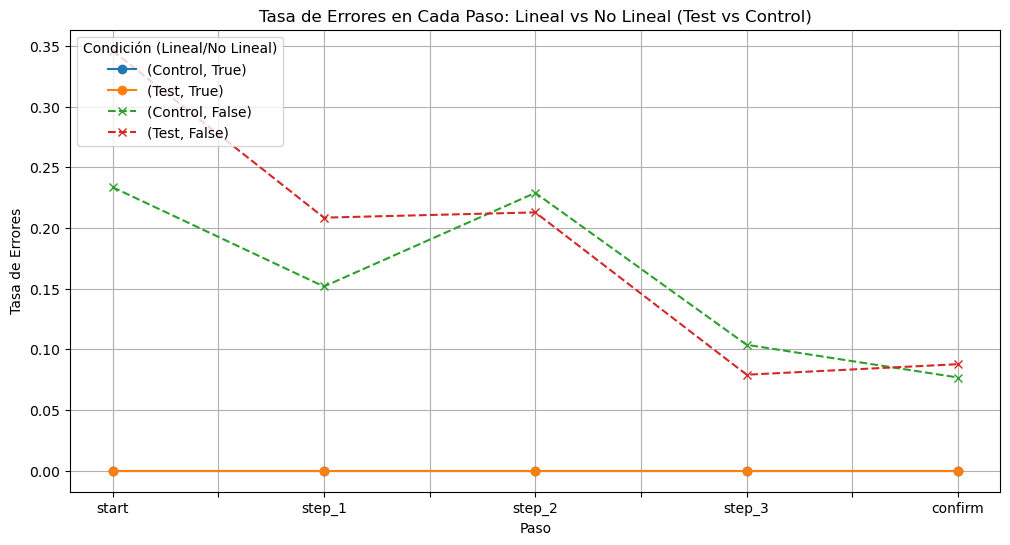

In [150]:
# Definir una nueva columna para marcar los errores (retrocesos o repeticiones mayores a 2)
df_pt['error'] = (df_pt['step_diff'] == -1) | (df_pt['step_repeat_count'] > 2)

# Calcular la tasa de errores por cada grupo (Test/Control), si es lineal/no lineal, y por paso
error_rate = df_pt.groupby(['variation', 'lineal', 'step'])['error'].mean().unstack()

# Definimos el orden correcto de los pasos
step_order = ['start', 'step_1', 'step_2', 'step_3', 'confirm']

# Reordenamos las columnas en error_rate para reflejar el orden correcto
error_rate = error_rate[step_order]

# Graficar la tasa de errores comparando Test/Control y si fueron lineales o no
plt.figure(figsize=(12, 6))

# Grafico para los que completaron de manera lineal (lineal=True)
error_rate.loc[(slice(None), True), :].T.plot(kind='line', marker='o', figsize=(12, 6), ax=plt.gca(), label="Lineal")

# Grafico para los que no completaron de manera lineal (lineal=False)
error_rate.loc[(slice(None), False), :].T.plot(kind='line', marker='x', linestyle='--', figsize=(12, 6), ax=plt.gca(), label="No Lineal")

plt.title('Tasa de Errores en Cada Paso: Lineal vs No Lineal (Test vs Control)')
plt.xlabel('Paso')
plt.ylabel('Tasa de Errores')
plt.grid(True)
plt.legend(title='Condición (Lineal/No Lineal)', loc='upper left')
plt.show()

In [151]:
error_rate

step                 start    step_1    step_2    step_3   confirm
variation lineal                                                  
Control   False   0.233686  0.151832  0.228995  0.103792  0.076825
          True    0.000000  0.000000  0.000000  0.000000  0.000000
Test      False   0.346152  0.208578  0.212911  0.079138  0.087799
          True    0.000000  0.000000  0.000000  0.000000  0.000000

#### Análisis de los principales clientes. 

- Por edad.

age_group       Young  Middle-aged     Senior
group                                        
Above Mean   8.480000    42.400000  49.120000
General     29.395285    36.471736  34.132979
Top 10%      0.943396    27.358491  71.698113


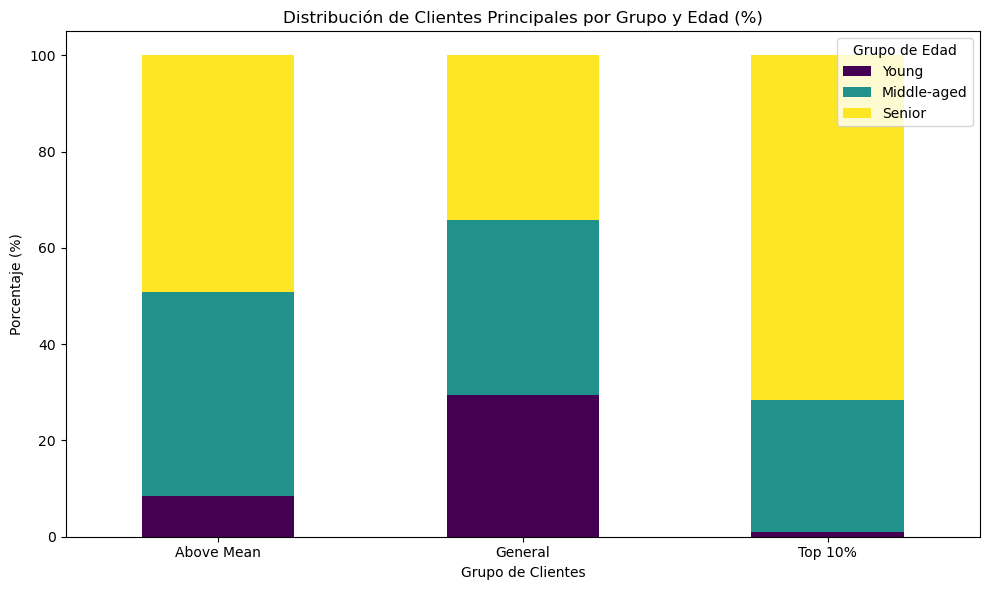

In [154]:
# Crear la tabla cruzada (crosstab) entre el grupo y la edad
age_group_crosstab = pd.crosstab(df_final['group'], df_final['age_group'], normalize='index') * 100

# Mostrar la tabla cruzada con porcentajes
print(age_group_crosstab)

# Crear el gráfico de barras apiladas (stacked bar chart) para visualizar la distribución
age_group_crosstab.plot(kind='bar', stacked=True, figsize=(10, 6), cmap='viridis')

# Agregar títulos y etiquetas
plt.title('Distribución de Clientes Principales por Grupo y Edad (%)')
plt.xlabel('Grupo de Clientes')
plt.ylabel('Porcentaje (%)')
plt.legend(title='Grupo de Edad')
plt.xticks(rotation=0)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


- Por género (excluimos 'U' y 'X').

gender              F          M
group                           
Above Mean  31.649832  68.350168
General     50.274105  49.725895
Top 10%     25.181598  74.818402


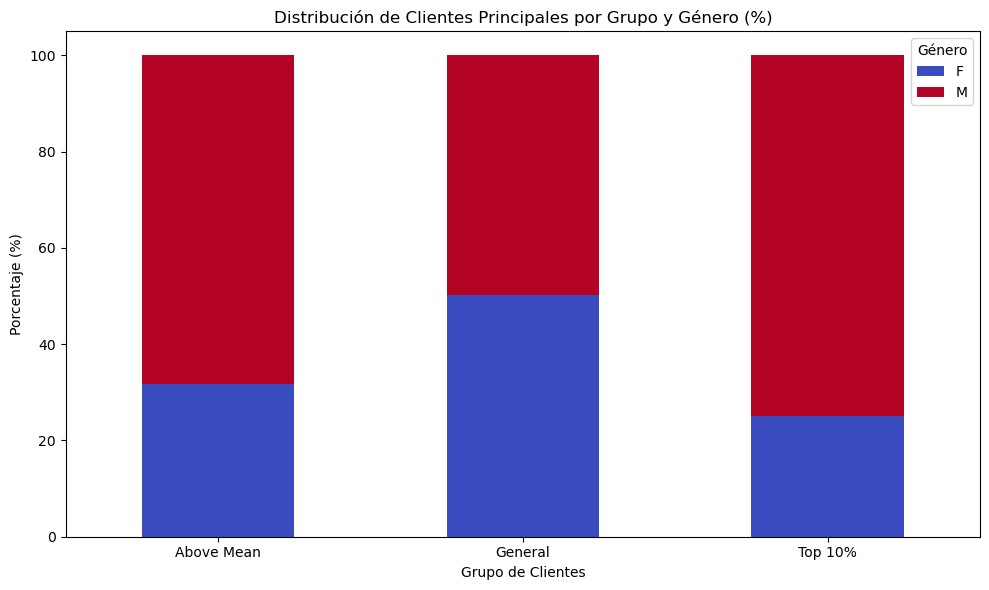

In [156]:
# Filtrar el DataFrame para excluir los géneros 'U' y 'X'
df_filtered = df_final[~df_final['gender'].isin(['U', 'X'])]

# Crear la tabla cruzada (crosstab) entre el grupo y el género
gender_group_crosstab = pd.crosstab(df_filtered['group'], df_filtered['gender'], normalize='index') * 100

# Mostrar la tabla cruzada con porcentajes
print(gender_group_crosstab)

# Crear el gráfico de barras apiladas (stacked bar chart) para visualizar la distribución
gender_group_crosstab.plot(kind='bar', stacked=True, figsize=(10, 6), cmap='coolwarm')

# Agregar títulos y etiquetas
plt.title('Distribución de Clientes Principales por Grupo y Género (%)')
plt.xlabel('Grupo de Clientes')
plt.ylabel('Porcentaje (%)')
plt.legend(title='Género')
plt.xticks(rotation=0)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

- Por número de cuentas.

num_accounts         1         2          3          4         5         6  \
group                                                                        
Above Mean    0.000000   0.00000  74.986667  20.906667  3.626667  0.480000   
General       0.002075  82.42716  15.099195   2.220470  0.228273  0.014526   
Top 10%       0.000000   0.00000  62.500000  29.009434  6.367925  1.650943   

num_accounts         7  
group                   
Above Mean    0.000000  
General       0.008301  
Top 10%       0.471698  


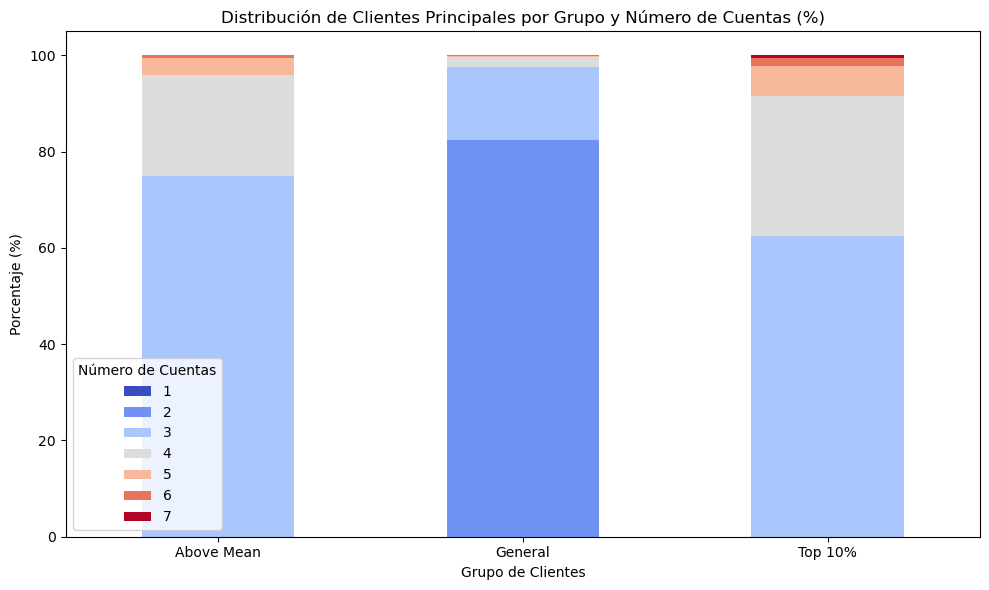

In [157]:
# Crear la tabla cruzada (crosstab) entre el grupo y el número de cuentas
num_accounts_group_crosstab = pd.crosstab(df_final['group'], df_final['num_accounts'], normalize='index') * 100

# Mostrar la tabla cruzada con porcentajes
print(num_accounts_group_crosstab)

# Crear el gráfico de barras apiladas (stacked bar chart) para visualizar la distribución
num_accounts_group_crosstab.plot(kind='bar', stacked=True, figsize=(10, 6), cmap='coolwarm')

# Agregar títulos y etiquetas
plt.title('Distribución de Clientes Principales por Grupo y Número de Cuentas (%)')
plt.xlabel('Grupo de Clientes')
plt.ylabel('Porcentaje (%)')
plt.legend(title='Número de Cuentas')
plt.xticks(rotation=0)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

- Por balance.

C:\Users\usr\AppData\Local\Temp\ipykernel_3712\1047612799.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y='balance', data=df_final, palette='coolwarm')


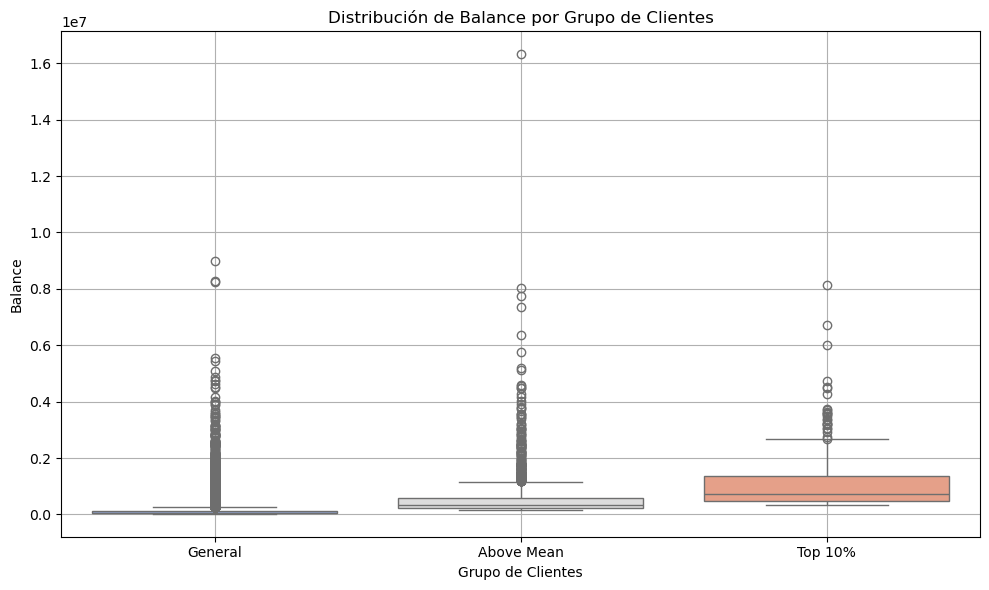

In [160]:
# Crear un boxplot para visualizar la distribución de balance por grupo
plt.figure(figsize=(10, 6))
sns.boxplot(x='group', y='balance', data=df_final, palette='coolwarm')

# Agregar títulos y etiquetas
plt.title('Distribución de Balance por Grupo de Clientes')
plt.xlabel('Grupo de Clientes')
plt.ylabel('Balance')
plt.grid(True)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

- Por activity

C:\Users\usr\AppData\Local\Temp\ipykernel_3712\779577693.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y='activity', data=df_final, palette='coolwarm')


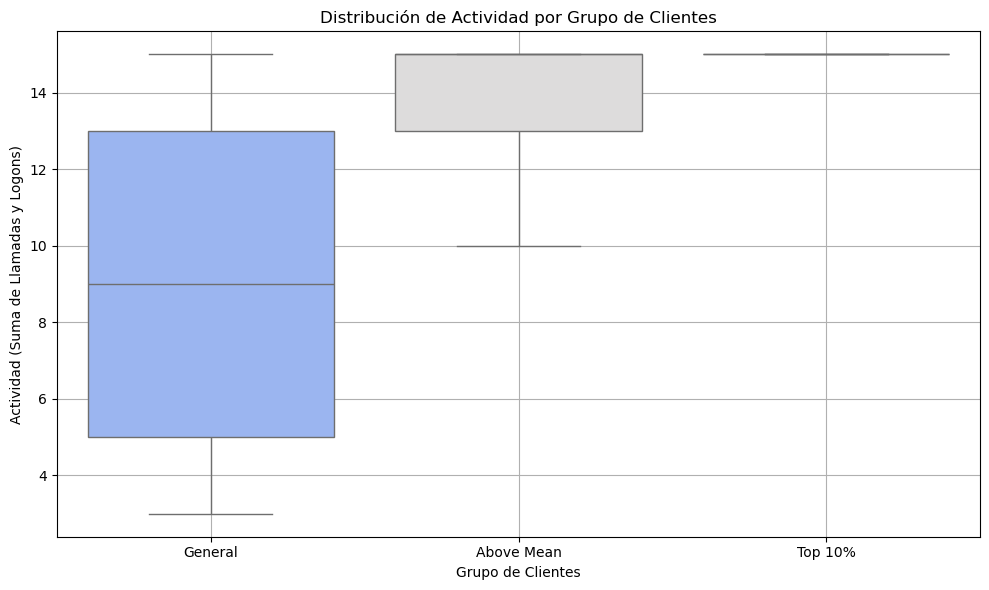

In [161]:
# Crear un boxplot para visualizar la distribución de la actividad por grupo
plt.figure(figsize=(10, 6))
sns.boxplot(x='group', y='activity', data=df_final, palette='coolwarm')

# Agregar títulos y etiquetas
plt.title('Distribución de Actividad por Grupo de Clientes')
plt.xlabel('Grupo de Clientes')
plt.ylabel('Actividad (Suma de Llamadas y Logons)')
plt.grid(True)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

- Análisis con group, variation y lineal

In [163]:
# Añadir la columna 'lineal' de df_pt a df_final basado en client_id
df_final = df_final.merge(df_pt[['client_id', 'lineal']], on='client_id', how='left')

In [164]:
# Crear una tabla cruzada entre 'group', 'variation' y 'lineal' con porcentajes
crosstab_group_variation_lineal = pd.crosstab([df_final['group']], [df_final['variation'], df_final['lineal']], normalize='index') * 100

# Mostrar la tabla cruzada con los porcentajes
print(crosstab_group_variation_lineal)

variation     Control                  Test           
lineal          False      True       False      True 
group                                                 
Above Mean  26.399759  17.971102  36.243227  19.385912
General     26.735949  17.529431  34.660459  21.074160
Top 10%     29.059011  18.149920  36.969697  15.821372


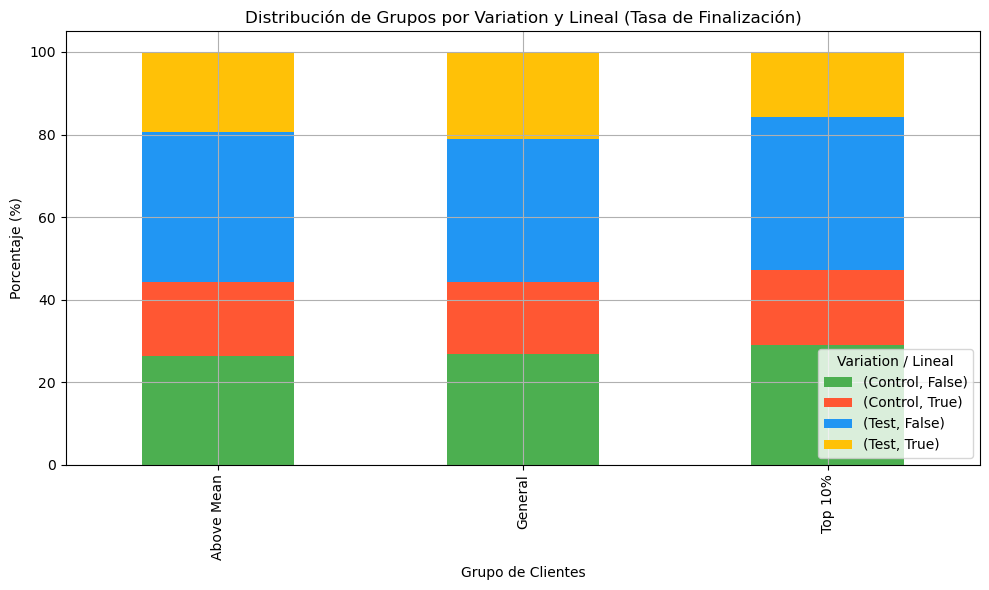

In [165]:
# Crear un gráfico de barras apiladas para visualizar la relación entre 'group', 'variation' y 'lineal'
crosstab_group_variation_lineal.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#4CAF50', '#FF5733', '#2196F3', '#FFC107'])

# Agregar títulos y etiquetas
plt.title('Distribución de Grupos por Variation y Lineal (Tasa de Finalización)')
plt.xlabel('Grupo de Clientes')
plt.ylabel('Porcentaje (%)')
plt.legend(title='Variation / Lineal')
plt.grid(True)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

#### Skewness y Kurtosis

- Es útil para entender la forma de distribución de los datos en relación a una distribución normal.

#### Skewness
- Valor cercano a 0: Distribución simétrica (similar a una normal).
- Valor positivo: Cola a la derecha, la mayoría de los clientes son rápidos, pero algunos muy lentos.
- Valor negativo: Cola a la izquierda, la mayoría de los clientes son lentos, pero algunos muy rápidos.

- La asimetría indica si la distribución de los datos está inclinada hacia un lado (sesgada). Podría ser útil aplicar skewness en los tiempos de cada paso 'total_time_in_step'

- Asimetría de los tiempos que los clientes han empleado en cada paso.

- Si la asimetría es positiva, indica que hay más clientes que pasan mucho menos tiempo en ese paso que la media, pero algunos tardan significativamente más.

- Si es negativa, significa que la mayoría de los clientes tardan más de lo esperado, con pocos que terminan rápido.

- Esto puede revelar diferencias importantes entre las versiones de la web (control vs test) en cuanto a la experiencia de usuario. Por ejemplo, si el tiempo en un paso clave está muy sesgado, puede señalar un problema de diseño o usabilidad que afecta a algunos usuarios.

#### Kurtosis
- Valor cercano a 3: Distribución normal.
- Valor mayor a 3: Colas más pesadas (outliers significativos).
- Valor menor a 3: Colas más ligeras (menos outliers de lo esperado).

- Dice si los datos tienen una cola más pesada o ligera que la distribución normal. Es decir, si los valores extremos (outliers) son más comunes de lo esperado. Kurtosis puede ser relevante para detectar problemas en el comportamiento de los clientes, como comportamiento atípico.

-  Si algunos clientes pasan tiempos extremadamente largos en ciertos pasos o tienen tasas de error mucho más altas en una versión (test/control), la kurtosis ayudaría a identificar estos casos.

-  Una alta curtosis indicaría que tenemos muchos valores atípicos, lo cual podría significar que ciertos clientes están encontrando dificultades significativas en la navegación.

In [173]:
# Agrupar por 'variation' (Test vs Control), 'step' y 'lineal' para calcular media, skewness y kurtosis de los tiempos
grouped_time_stats = df_pt.groupby(['variation', 'step', 'lineal'])['total_time_in_step'].agg(
    mean='mean',
    skew=lambda x: skew(x),
    kurtosis=lambda x: kurtosis(x)
)

# Mostrar los resultados
print(grouped_time_stats)

                                mean       skew     kurtosis
variation step    lineal                                    
Control   confirm False   255.394645   3.321375    24.136983
                  True    289.998462   7.132935   198.923587
          start   False    74.734189  53.047229  5255.297400
                  True     12.470965  44.862473  3083.136342
          step_1  False    87.124677   8.705658   131.364376
                  True     37.820651   7.914858    93.876989
          step_2  False   103.223602   7.533269    93.813236
                  True     72.524611   5.680865    54.416987
          step_3  False   184.890220   9.810619   263.983401
                  True    169.012851   3.421146    20.173019
Test      confirm False   210.016980   9.274104   280.210065
                  True    250.060112   4.486952    46.817393
          start   False    87.029394  24.079085  1571.256265
                  True      7.906919  20.696962   548.422417
          step_1  False 

#### Media (Mean)
La media indica el tiempo promedio (en segundos) que los clientes pasaron en cada paso. Observamos que:

- Confirm: Los usuarios en el grupo Control que completaron el proceso de manera lineal (True) pasan, en promedio, más tiempo en el paso final ("confirm") que aquellos que no lo hicieron linealmente. En el grupo Test, ocurre lo mismo.

- Start: El tiempo promedio en el paso "start" es mucho menor para los usuarios que completaron el proceso de manera lineal en ambos grupos. Esto sugiere que los usuarios lineales inician rápidamente, mientras que los que no completan el proceso tienden a detenerse en este paso.

- Step_1 a Step_3: De manera consistente, los clientes que siguen un proceso lineal suelen pasar menos tiempo en cada paso en comparación con los no lineales.

#### Asimetría (Skewness)
La asimetría nos dice si los datos están sesgados hacia un lado de la media:

- Valores altos de asimetría, como los observados en pasos como start (por ejemplo, 53.05 en Control-False), indican que hay una gran concentración de tiempos bajos en los primeros pasos, pero también algunos clientes pasan mucho más tiempo en esos pasos.

- La alta asimetría en el grupo Test-False en el paso start (24.08) sugiere que hay usuarios que, aunque la mayoría se detiene brevemente, algunos pasan tiempos excesivamente largos en este paso, lo que probablemente indica errores o confusión.


#### Kurtosis
La curtosis mide la "cola" de la distribución, es decir, si los datos tienen más valores extremos de lo esperado (kurtosis alta) o si están más concentrados cerca de la media (kurtosis baja):

- Kurtosis muy alta (como 5255.29 en Control-False-start) indica que hay una cantidad significativa de usuarios que pasaron tiempos extremadamente largos en esos pasos. Esto es típico de clientes que están atascados o que no siguen el proceso lineal.

- Para los usuarios lineales (True), las kurtosis son generalmente menores, lo que sugiere una distribución más concentrada alrededor de la media.

#### Lineales (True) y No lineales (False)

- Lineales (True): En general, los usuarios que completan el proceso de manera lineal pasan menos tiempo en cada paso y tienen distribuciones más equilibradas (kurtosis y skewness más bajas) en comparación con aquellos que no siguen el proceso lineal.

- No lineales (False): Los usuarios no lineales muestran tiempos promedio más largos, distribuciones más sesgadas (skewness alta) y más dispersas (kurtosis alta), lo que indica que algunos se quedan atrapados en ciertos pasos o toman decisiones que los alejan del flujo natural del proceso.

#### Conclusión

- Los clientes que completan el proceso de manera lineal tienen un comportamiento más eficiente y consistente, mientras que los que no lo completan tienden a quedar atascados en ciertos pasos, especialmente al principio (start y step_1), lo que podría indicar problemas de usabilidad en estos pasos.

- Este análisis sugiere que el grupo Test parece tener una menor media en algunos pasos para los usuarios lineales en comparación con Control, lo que podría indicar una mejora en la experiencia de la nueva versión de la web. Sin embargo, los usuarios que no siguen el proceso lineal tienen tiempos más prolongados y distribuciones más extremas.

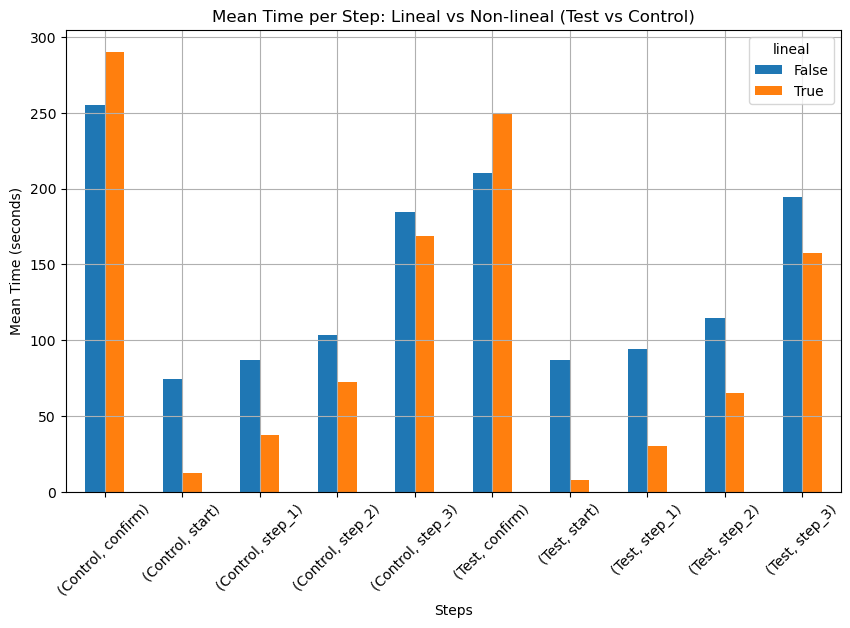

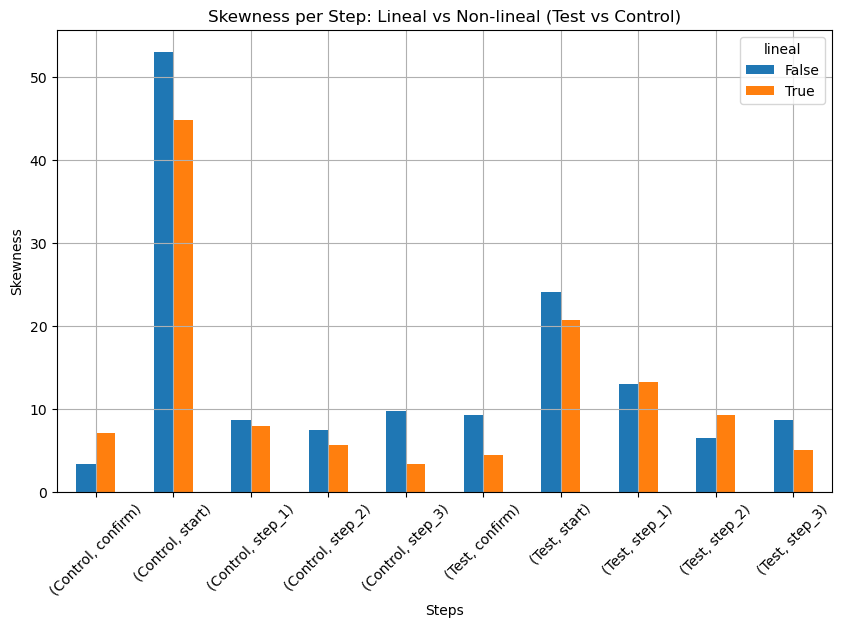

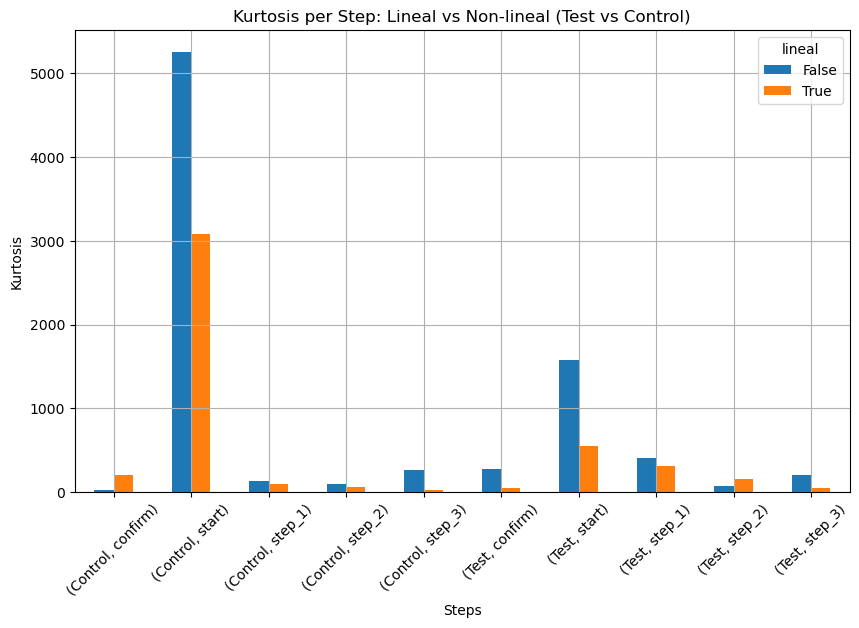

In [174]:
# Graficar la media (mean)
fig, ax = plt.subplots(figsize=(10, 6))
grouped_time_stats['mean'].unstack().plot(kind='bar', ax=ax)
ax.set_title('Mean Time per Step: Lineal vs Non-lineal (Test vs Control)')
ax.set_ylabel('Mean Time (seconds)')
ax.set_xlabel('Steps')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Graficar el skewness
fig, ax = plt.subplots(figsize=(10, 6))
grouped_time_stats['skew'].unstack().plot(kind='bar', ax=ax)
ax.set_title('Skewness per Step: Lineal vs Non-lineal (Test vs Control)')
ax.set_ylabel('Skewness')
ax.set_xlabel('Steps')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Graficar la kurtosis
fig, ax = plt.subplots(figsize=(10, 6))
grouped_time_stats['kurtosis'].unstack().plot(kind='bar', ax=ax)
ax.set_title('Kurtosis per Step: Lineal vs Non-lineal (Test vs Control)')
ax.set_ylabel('Kurtosis')
ax.set_xlabel('Steps')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

- Histograma: permiten observar la distribución de frecuencias del tiempo total en cada paso, para los grupos Test vs Control y también lineal vs no lineal.

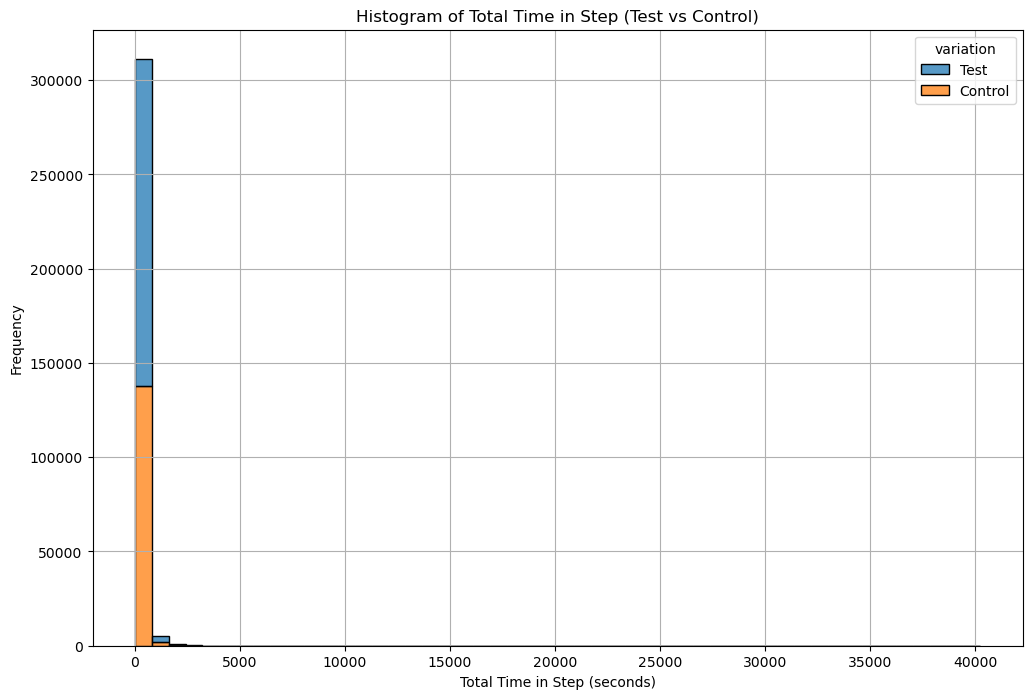

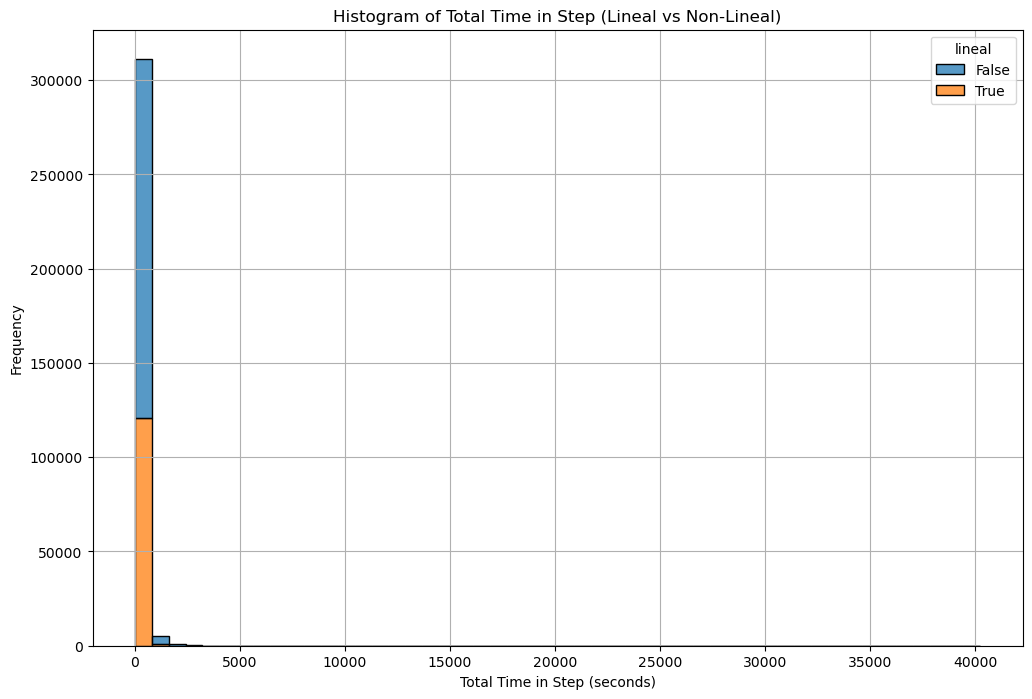

In [175]:
# Histograma para los tiempos en cada paso por Test vs Control y Lineal vs No Lineal
plt.figure(figsize=(12, 8))
sns.histplot(data=df_pt, x='total_time_in_step', hue='variation', multiple="stack", bins=50)
plt.title('Histogram of Total Time in Step (Test vs Control)')
plt.xlabel('Total Time in Step (seconds)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Histograma separado por Lineal vs No Lineal
plt.figure(figsize=(12, 8))
sns.histplot(data=df_pt, x='total_time_in_step', hue='lineal', multiple="stack", bins=50)
plt.title('Histogram of Total Time in Step (Lineal vs Non-Lineal)')
plt.xlabel('Total Time in Step (seconds)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

- Boxplot: muestran la distribución estadística de los tiempos (mediana, cuartiles) y destacarán los valores atípicos.

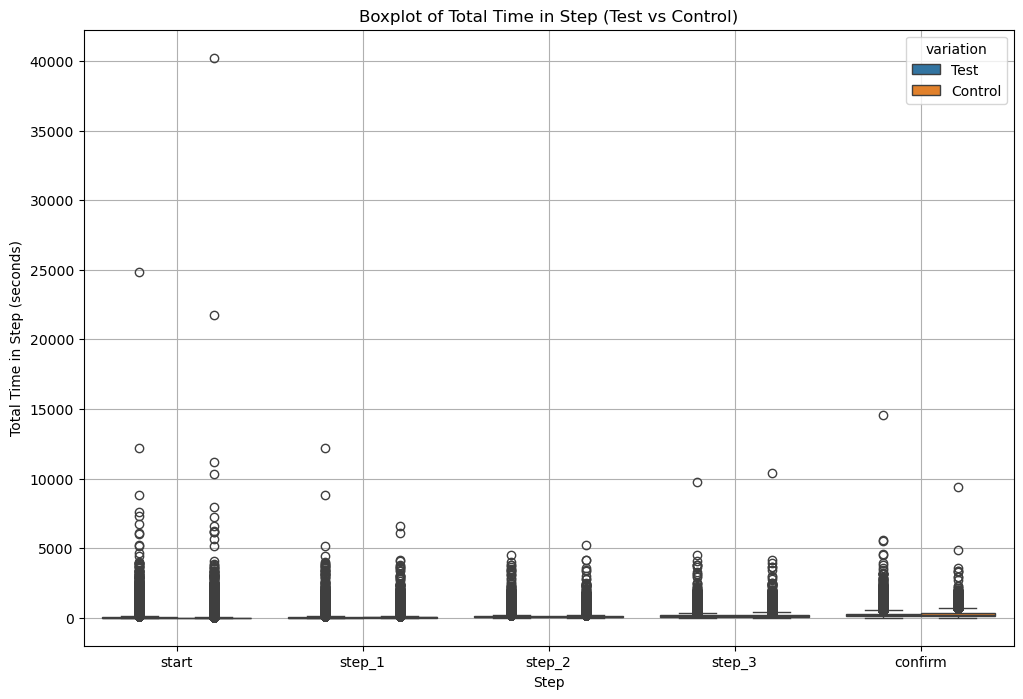

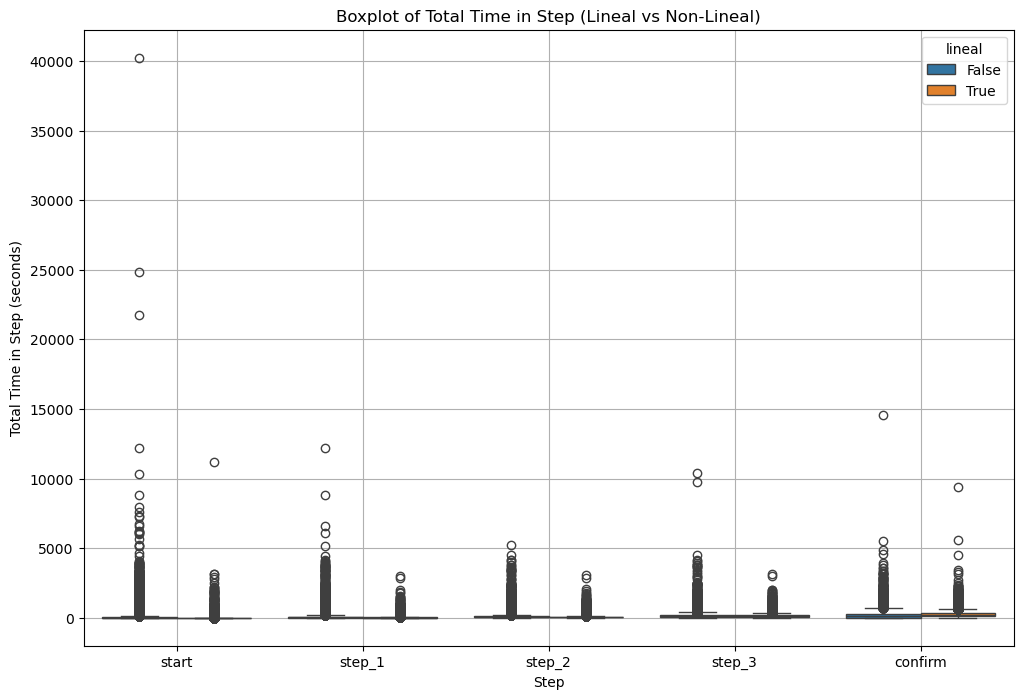

In [176]:
# Boxplot para ver la distribución del tiempo en cada paso por Test vs Control
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_pt, x='step', y='total_time_in_step', hue='variation')
plt.title('Boxplot of Total Time in Step (Test vs Control)')
plt.xlabel('Step')
plt.ylabel('Total Time in Step (seconds)')
plt.grid(True)
plt.show()

# Boxplot para ver la distribución del tiempo en cada paso por Lineal vs No Lineal
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_pt, x='step', y='total_time_in_step', hue='lineal')
plt.title('Boxplot of Total Time in Step (Lineal vs Non-Lineal)')
plt.xlabel('Step')
plt.ylabel('Total Time in Step (seconds)')
plt.grid(True)
plt.show()

#### Chi-Square Test

- El chi-square test es útil cuando se comparan variables categóricas. En este caso, evaluamos si la distribución de usuarios que completan el proceso (lineal=True/False) es diferente entre el grupo Test y Control.

- Hipótesis nula: No hay diferencia en la proporción de usuarios que completan el proceso de manera lineal entre Test y Control.

- Hipótesis alternativa: Hay una diferencia en la proporción.

- Si el valor p es menor que 0.05, puedes rechazar la hipótesis nula y concluir que existe una diferencia significativa en el comportamiento entre los usuarios de Test y Control.

In [178]:
from scipy.stats import chi2_contingency

# Crear una tabla de contingencia entre 'variation' y 'lineal'
contingency_table = pd.crosstab(df_pt['variation'], df_pt['lineal'])

# Aplicar chi-square test
chi2, p, dof, ex = chi2_contingency(contingency_table)
print(f"Chi-square statistic: {chi2}, p-value: {p}")

Chi-square statistic: 133.72983155146625, p-value: 6.259980648958378e-31


- Dado que el p-value es muy pequeño (mucho menor que 0.05), podemos rechazar la hipótesis nula. Esto significa que existe una diferencia significativa en la proporción de usuarios que completaron el proceso de manera lineal entre los grupos Test y Control.

- Hay evidencia estadística para afirmar que el comportamiento de los usuarios en cuanto a completar el proceso de manera lineal (o no) varía significativamente entre los que usaron la versión antigua de la web (Control) y los que usaron la nueva versión (Test).

#### Cramér's V

 - Es una medida de asociación entre variables categóricas, basada en el chi-square. Nos es útil para medir la fuerza de la relación entre variables como variation (Test vs Control) y lineal (True vs False).

 - Cramér's V te indicará la fuerza de la asociación entre el tipo de web y si el usuario completó el proceso de manera lineal.

In [180]:
# Calcular Cramér's V
n = contingency_table.sum().sum()  # Número total de observaciones
cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
print(f"Cramér's V: {cramers_v}")

Cramér's V: 0.020535263416396086


- 0 indica que no hay asociación entre las variables.
- 1 indica una asociación perfecta.
- 0.0205 es un valor muy bajo, lo que sugiere que, aunque la prueba Chi-cuadrado mostró una diferencia significativa entre Test y Control en términos de la finalización lineal del proceso, la fuerza de la asociación es muy débil.

- Aunque hay una diferencia estadísticamente significativa en la tasa de finalización lineal entre las versiones de la web, la magnitud de la diferencia es pequeña, es decir, el comportamiento de los usuarios (completar o no el proceso de manera lineal) no depende mucho de la versión de la web que usaron.

- Esto podría indicar que, si bien hay una diferencia, esta no es lo suficientemente fuerte como para ser decisiva en términos prácticos. Podría ser útil explorar otros factores o realizar un análisis más profundo, como desglosar por pasos o grupos demográficos, para ver si la asociación es más fuerte en ciertos subconjuntos.

#### Stacked and Grouped Bar Charts

- Comparar la proporción de usuarios lineales y no lineales en Test vs Control.

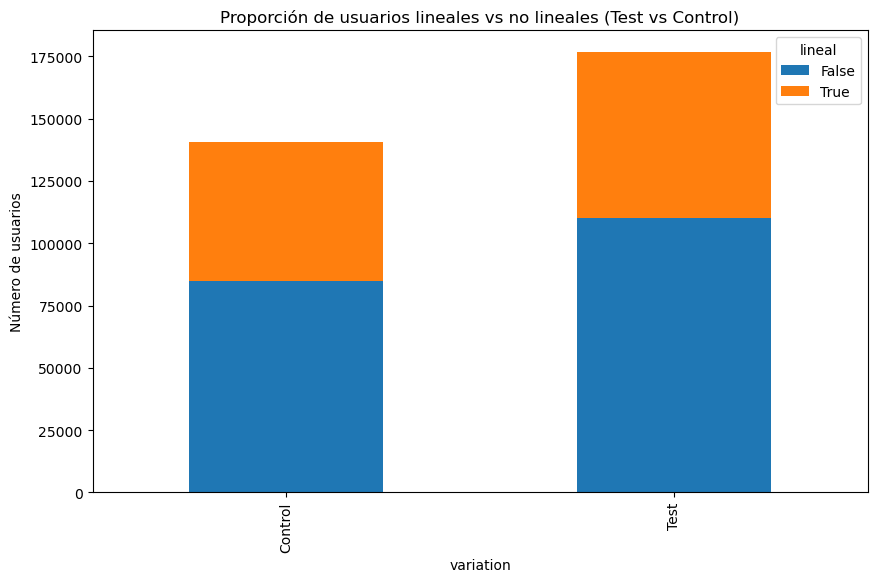

In [181]:
# Crear gráfico de barras apiladas para visualizar la proporción de lineal vs no lineal en Test vs Control
df_pt.groupby(['variation', 'lineal']).size().unstack().plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Proporción de usuarios lineales vs no lineales (Test vs Control)')
plt.ylabel('Número de usuarios')
plt.show()

#### Frequency Heat Maps

- Para visualizar matrices de frecuencias entre dos variables. Observamos las frecuencias entre step y variation o entre lineal y group.

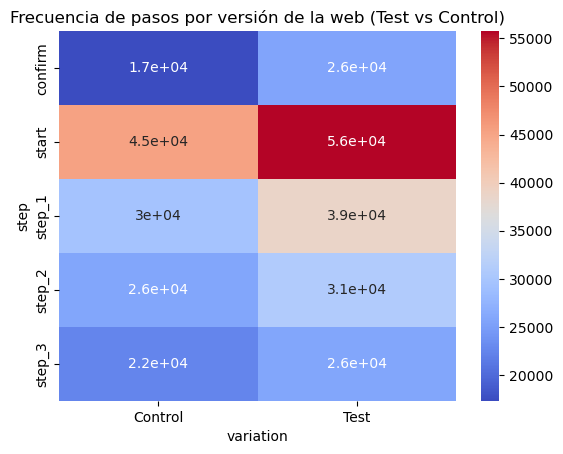

In [182]:
# Crear una tabla de frecuencias entre 'step' y 'variation'
freq_table = pd.crosstab(df_pt['step'], df_pt['variation'])

# Visualizar con heatmap
sns.heatmap(freq_table, annot=True, cmap='coolwarm')
plt.title('Frecuencia de pasos por versión de la web (Test vs Control)')
plt.show()

#### Violin Plots

- Combinan un box plot con una distribución de densidad. Serían útiles para comparar la distribución de tiempos en los pasos entre Test y Control, o entre lineal y no lineal.

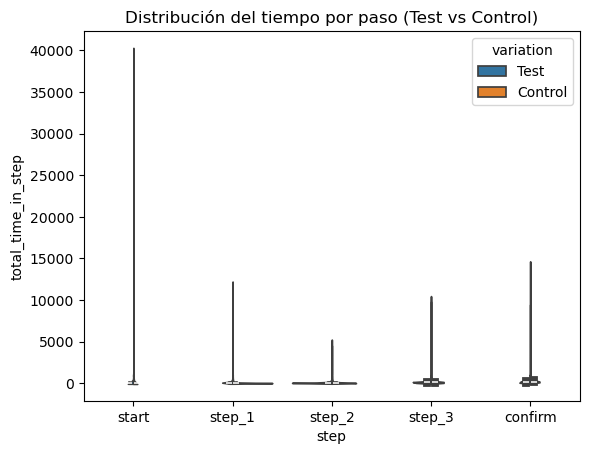

In [183]:
# Violin plot para comparar el tiempo en cada paso entre Test y Control
sns.violinplot(x='step', y='total_time_in_step', hue='variation', data=df_pt, split=True)
plt.title('Distribución del tiempo por paso (Test vs Control)')
plt.show()

#### Side-by-Side Box Plots

- Comparar la distribución de los tiempos en diferentes pasos entre Test y Control, así como para ver diferencias entre lineales y no lineales.

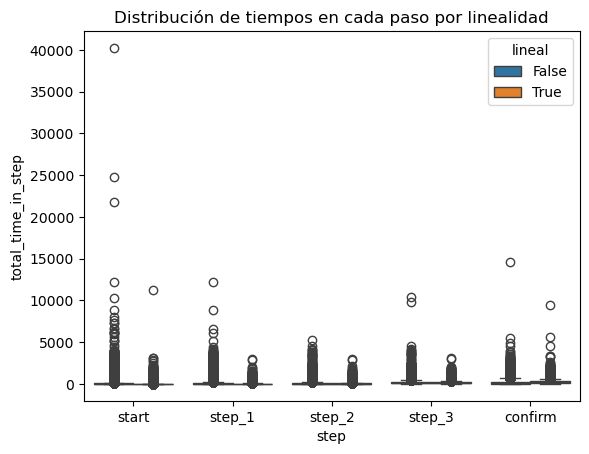

In [184]:
# Boxplot para comparar el tiempo en cada paso por versión (Test vs Control) y linealidad
sns.boxplot(x='step', y='total_time_in_step', hue='lineal', data=df_pt)
plt.title('Distribución de tiempos en cada paso por linealidad')
plt.show()

#### Bar Charts

- Para analizar categorías como el número de cuentas (num_accounts), grupos (group), o el género de los usuarios en relación con Test y Control.

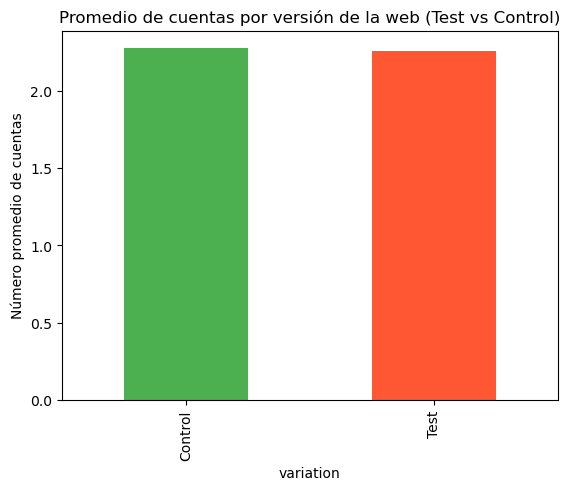

In [185]:
# Comparar el número de cuentas en Test vs Control
df_final.groupby('variation')['num_accounts'].mean().plot(kind='bar', color=['#4CAF50', '#FF5733'])
plt.title('Promedio de cuentas por versión de la web (Test vs Control)')
plt.ylabel('Número promedio de cuentas')
plt.show()

#### Coeficientes de correlación (Pearson y Spearman)

#### Pearson

- Mide la correlación lineal entre dos variables continuas (como tiempos de finalización y otros valores numéricos).

- Pearson es útil para ver si hay una relación lineal entre los tiempos de finalización en cada paso y otras variables numéricas como la edad, el balance, o la actividad de los clientes. Podemos ver si a mayor actividad los tiempos en los pasos son menores.

#### Spearman

- Mide correlaciones monótonas (relaciones que pueden no ser lineales).

- Es más adecuado si esperamos que la relación entre las variables sea no lineal, por ejemplo, si sospechamos que el aumento en la actividad tiene un impacto no constante en los tiempos de finalización.

Pearson Correlation:
                balance  activity       age  num_accounts
balance       1.000000  0.171125  0.201108      0.264194
activity      0.171125  1.000000  0.080642      0.239670
age           0.201108  0.080642  1.000000     -0.014992
num_accounts  0.264194  0.239670 -0.014992      1.000000
Spearman Correlation:
                balance  activity       age  num_accounts
balance       1.000000  0.289570  0.346723      0.333328
activity      0.289570  1.000000  0.082088      0.243696
age           0.346723  0.082088  1.000000     -0.024591
num_accounts  0.333328  0.243696 -0.024591      1.000000


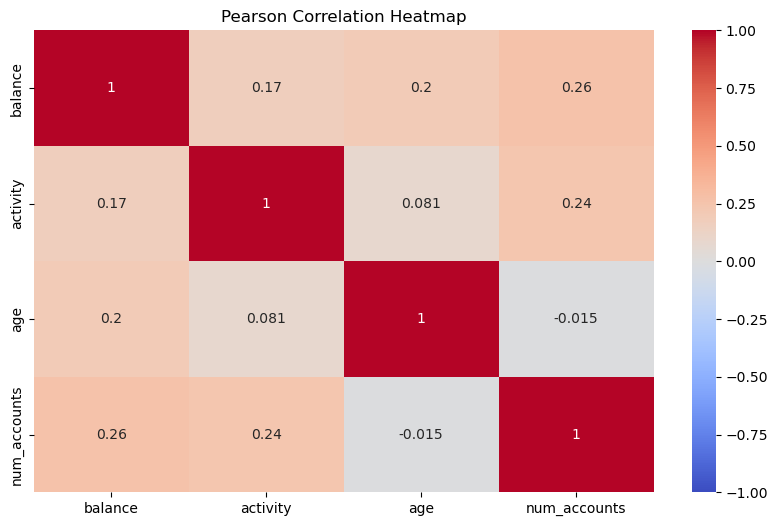

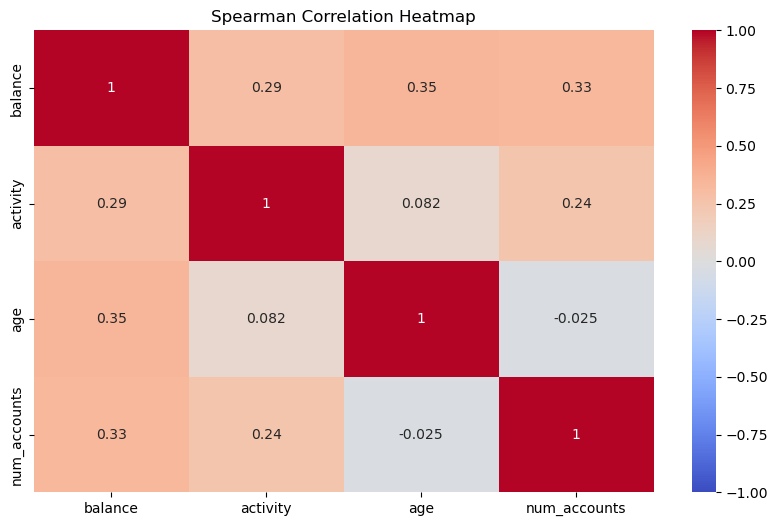

In [186]:
# Pearson Correlation
pearson_corr = df_final[['balance', 'activity', 'age', 'num_accounts']].corr(method='pearson')
print("Pearson Correlation:\n", pearson_corr)

# Spearman Correlation
spearman_corr = df_final[['balance', 'activity', 'age', 'num_accounts']].corr(method='spearman')
print("Spearman Correlation:\n", spearman_corr)

# Visualizar con heatmaps
plt.figure(figsize=(10,6))
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Pearson Correlation Heatmap')
plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Spearman Correlation Heatmap')
plt.show()

- 1 indica una correlación positiva perfecta.
- 0 indica que no hay correlación.
- -1 indica una correlación negativa perfecta.

- Pearson:

    - Balance y actividad tienen una correlación positiva baja (0.171). Esto sugiere que los clientes con mayores balances tienen un ligero incremento en la actividad.

    - Balance y edad tienen una correlación positiva moderada (0.201), lo que indica que a medida que aumenta la edad, el balance también tiende a ser mayor.

    - Balance y número de cuentas tienen una correlación positiva moderada (0.264), lo que significa que los clientes con más cuentas tienden a tener un balance más alto.

    - Actividad y número de cuentas tienen una correlación moderada (0.240), indicando que los clientes con más cuentas también son más activos.

    - Edad y actividad (0.081) y edad y número de cuentas (-0.015) tienen correlaciones muy bajas, lo que sugiere poca o ninguna relación entre estas variables.

- Spearman:

    - Balance y actividad muestran una correlación más fuerte (0.290) en Spearman que en Pearson, lo que sugiere que aunque la relación no es estrictamente lineal, hay una tendencia a que los clientes con balances más altos tengan más actividad.

    - Balance y edad también tienen una correlación más fuerte (0.347), sugiriendo una relación más significativa a medida que los clientes mayores tienden a tener balances más altos.

    - Balance y número de cuentas (0.333) también presentan una relación más fuerte, lo que refuerza que los clientes con más cuentas tienden a tener balances más elevados.

    - Actividad y número de cuentas (0.244) siguen mostrando una correlación moderada, lo que indica que los clientes con más cuentas suelen ser más activos.

    - Edad y actividad (0.082) y edad y número de cuentas (-0.025) siguen mostrando correlaciones bajas, sugiriendo poca relación entre estas variables.

- Conclusión:

    - La correlación más fuerte observada es entre balance y edad, así como entre balance y número de cuentas, lo que sugiere que los clientes más antiguos y aquellos con más cuentas tienden a tener balances más altos.
    
    - La correlación entre actividad y balance es moderada, sugiriendo que los clientes más activos tienden a tener balances ligeramente mayores.

    - Las correlaciones entre edad y otras variables (actividad y número de cuentas) son bastante bajas, lo que indica que la edad no está fuertemente relacionada con la actividad o el número de cuentas.

#### Heatmaps de Correlación

-  Útil cuando queremos ver cómo varias variables numéricas (como edad, balance, actividad, tiempos en los pasos, etc.) se relacionan entre sí. Esto puede ayudarte a detectar patrones en tus datos sobre si los clientes con más cuentas o actividad tienen diferentes tiempos de finalización en los pasos o si hay otros factores importantes.

- Podemos crear un heatmap de correlación para el grupo "test" y otro para "control" para comparar cómo las variables se comportan entre los dos grupos.

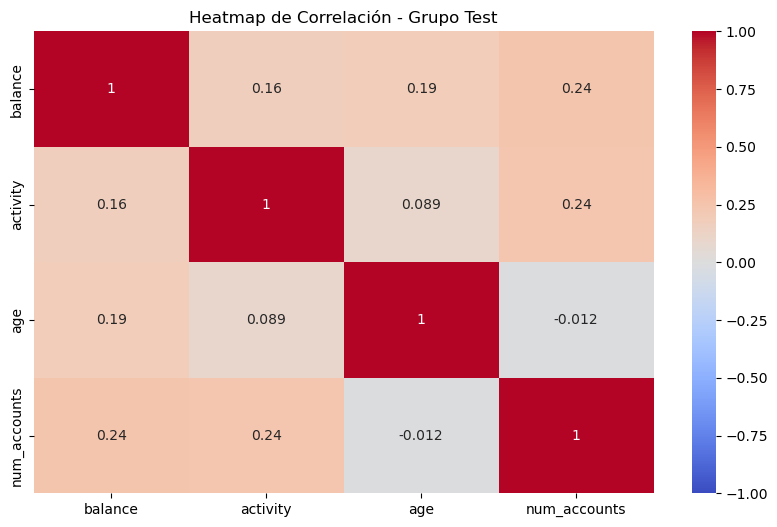

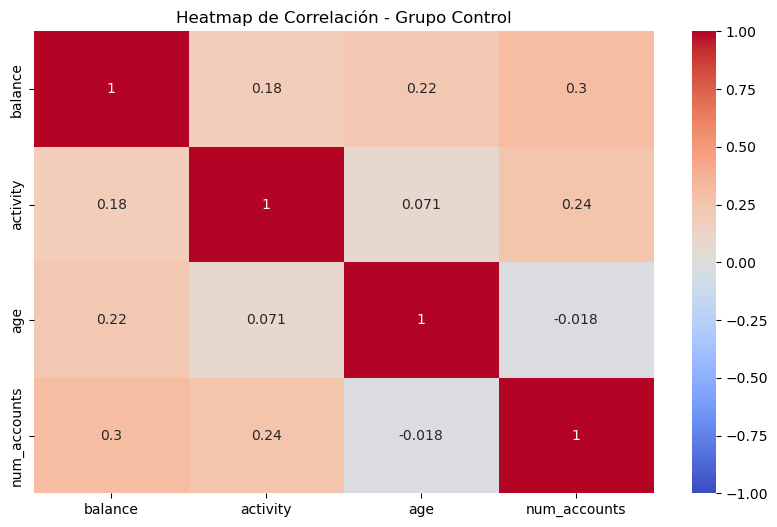

In [194]:
# Seleccionamos las variables numéricas que queremos incluir en el heatmap
variables_numericas = ['balance', 'activity', 'age', 'num_accounts']

# Filtramos por los grupos de 'Test' y 'Control'
df_test = df_final[df_final['variation'] == 'Test']
df_control = df_final[df_final['variation'] == 'Control']

# Calculamos la correlación de Pearson para 'Test' y 'Control'
corr_test = df_test[variables_numericas].corr(method='pearson')
corr_control = df_control[variables_numericas].corr(method='pearson')

# Crear heatmap para el grupo 'Test'
plt.figure(figsize=(10, 6))
sns.heatmap(corr_test, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap de Correlación - Grupo Test')
plt.show()

# Crear heatmap para el grupo 'Control'
plt.figure(figsize=(10, 6))
sns.heatmap(corr_control, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap de Correlación - Grupo Control')
plt.show()

#### Diagramas de Dispersión (Scatter Plots)


- Para visualizar la relación entre dos variables continuas, como el tiempo de finalización en los pasos y la edad o el balance. Esto te permite ver patrones visuales en los datos, como si el tiempo en ciertos pasos aumenta o disminuye a medida que los clientes tienen un balance más alto o si los usuarios más jóvenes tienden a completar los pasos más rápido.

- Podemos comparar el grupo de test vs control usando diferentes colores o símbolos para ver visualmente las diferencias en el rendimiento.

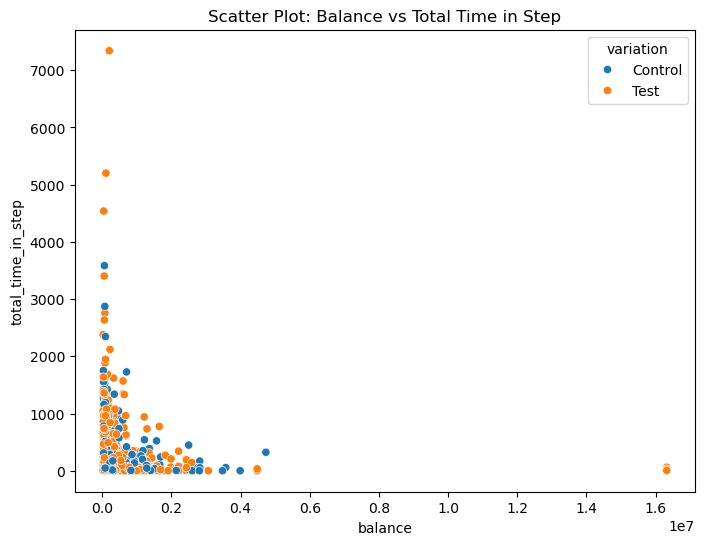

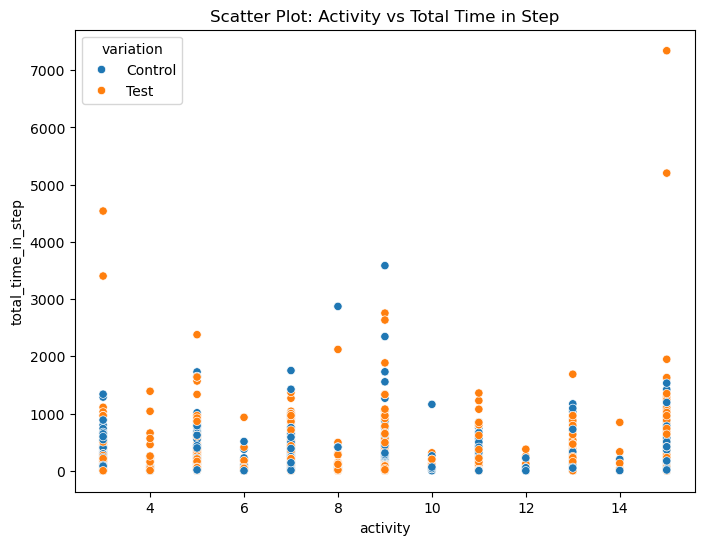

In [201]:
# Hacemos un merge entre df_final y df_pt para incluir 'total_time_in_step'
df_merged = pd.merge(df_final, df_pt[['client_id', 'total_time_in_step']], on='client_id')

# Tomar una muestra aleatoria de 5000 filas para hacer la visualización más rápida
df_sample = df_merged.sample(n=5000, random_state=42)

# Scatter plot para balance y tiempo total
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_sample, x='balance', y='total_time_in_step', hue='variation')
plt.title('Scatter Plot: Balance vs Total Time in Step')
plt.show()

# Scatter plot para actividad y tiempo total
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_sample, x='activity', y='total_time_in_step', hue='variation')
plt.title('Scatter Plot: Activity vs Total Time in Step')
plt.show()

#### Seaborn Joint Plot

- Útil para visualizar la relación entre dos variables continuas (como tiempos de paso y actividad), y también proporciona histogramas de las distribuciones de esas variables, lo que te permite entender la distribución de los datos y ver si hay outliers.

- Podría ser útil para comparar los tiempos de finalización y otras métricas como balance o número de cuentas de los clientes.

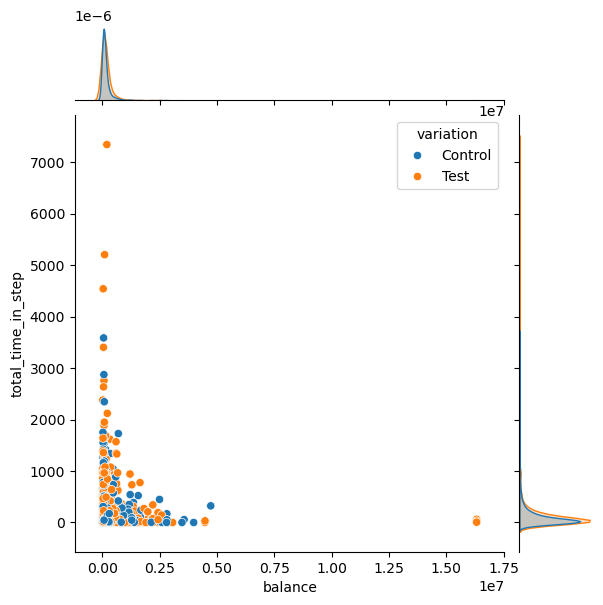

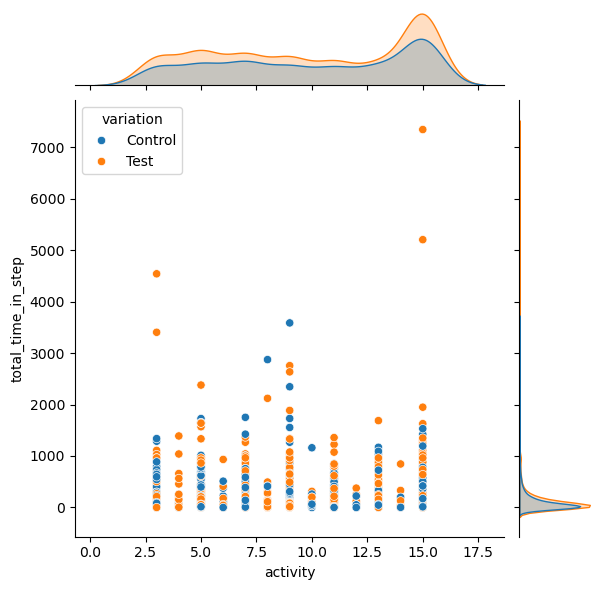

In [207]:
# Tomar una muestra aleatoria de 5000 filas para hacer la visualización más rápida
df_sample = df_merged.sample(n=5000, random_state=42)

# Joint plot entre balance y tiempo total
sns.jointplot(data=df_sample, x='balance', y='total_time_in_step', kind='scatter', hue='variation')
plt.show()

# Joint plot entre actividad y tiempo total
sns.jointplot(data=df_sample, x='activity', y='total_time_in_step', kind='scatter', hue='variation')
plt.show()

#### Seaborn Pairplot

- Para ver la relación entre varias variables numéricas a la vez. Podríamos ver las relaciones entre "balance", "actividad", "num_accounts", "edad" y los tiempos de finalización en cada paso. Además, podemos colorear los puntos por "test" y "control" para ver si hay diferencias en esos grupos.

- También podríamos incluir la variable lineal para ver cómo afecta si los clientes completaron correctamente el proceso o no.

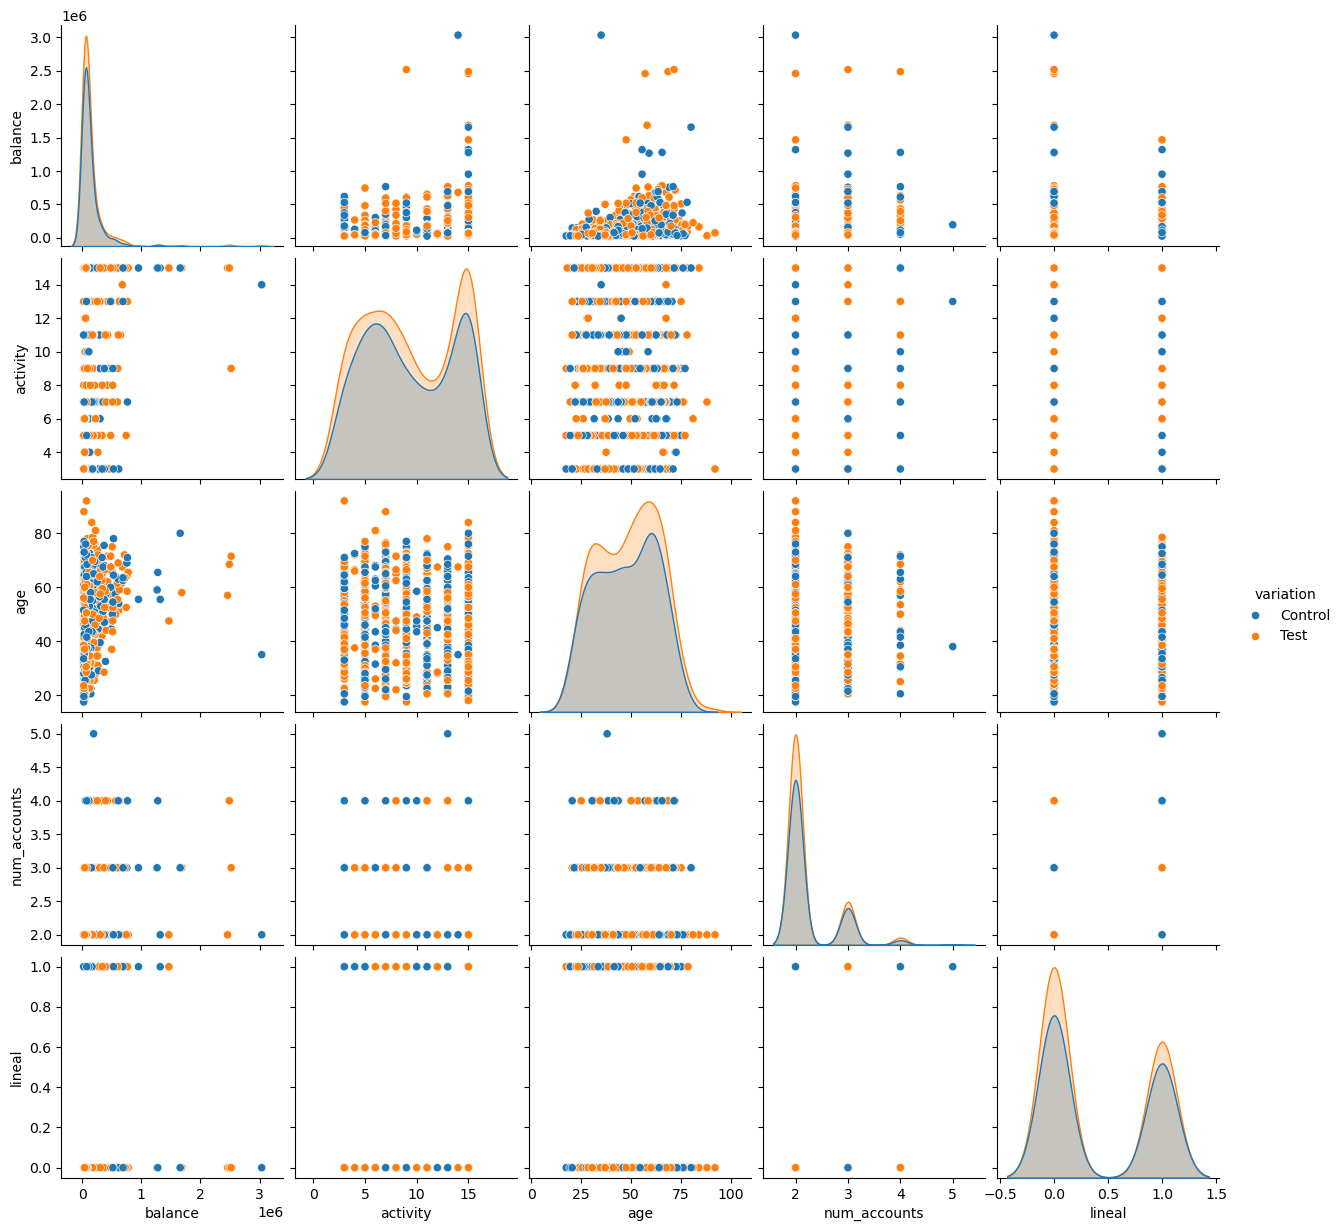

In [192]:
# Selecciona una muestra aleatoria de 1000 filas para reducir el tamaño
df_sample = df_final[['balance', 'activity', 'age', 'num_accounts', 'variation', 'lineal']].sample(1000, random_state=42)

# Genera el pairplot con la variable 'lineal' incluida y coloreada por 'variation'
sns.pairplot(df_sample, hue='variation')
plt.show()

#### Seaborn lmplot

- Es un gráfico de dispersión con una línea de regresión ajustada. Esto es útil si quieres observar la tendencia de los tiempos de finalización en relación con variables como la edad o balance.

- Podemos crear un lmplot para "test" y "control" para ver si hay alguna tendencia que muestre que, por ejemplo, en el grupo de "test" los clientes con mayor balance tienden a terminar los pasos más rápido.

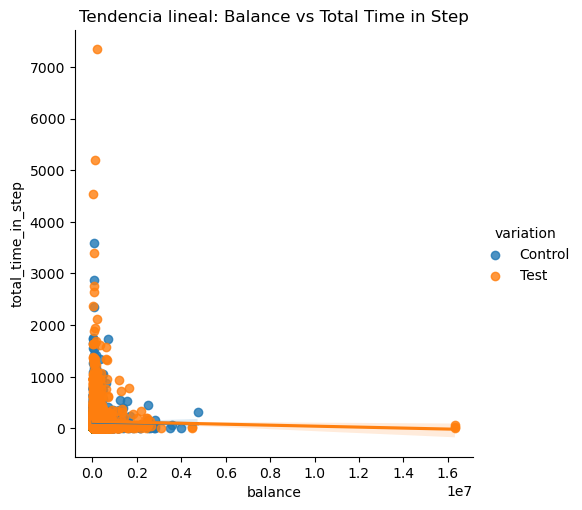

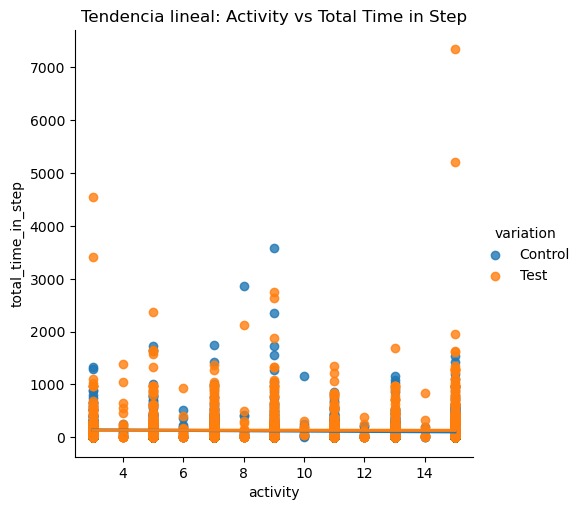

In [210]:
# Tomar una muestra aleatoria de 5000 filas para hacer la visualización más rápida
df_sample = df_merged.sample(n=5000, random_state=42)

# lmplot para ver la tendencia entre balance y tiempo total
sns.lmplot(data=df_sample, x='balance', y='total_time_in_step', hue='variation')
plt.title('Tendencia lineal: Balance vs Total Time in Step')
plt.show()

# lmplot para ver la tendencia entre actividad y tiempo total
sns.lmplot(data=df_sample, x='activity', y='total_time_in_step', hue='variation')
plt.title('Tendencia lineal: Activity vs Total Time in Step')
plt.show()

#### Gráficos de Línea (Line Plots)

- Para comparar las medias de los tiempos en cada paso entre "test" y "control"

- También podemos usar line plots para ver cómo los tiempos cambian entre los pasos en relación a la variable lineal (si los clientes completaron el proceso correctamente o no).

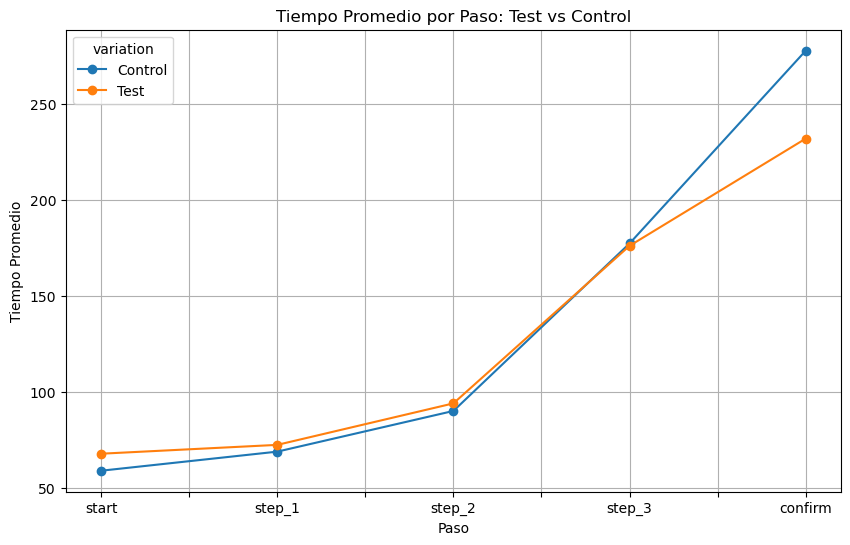

In [211]:
# Gráficos de línea para tiempos de cada paso
df_time_per_step = df_pt.groupby(['variation', 'step'])['total_time_in_step'].mean().unstack()

step_order = ['start', 'step_1', 'step_2', 'step_3', 'confirm']
df_time_per_step = df_time_per_step[step_order]

df_time_per_step.T.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Tiempo Promedio por Paso: Test vs Control')
plt.xlabel('Paso')
plt.ylabel('Tiempo Promedio')
plt.grid(True)
plt.show()

#### QQ Plot

- Útil para verificar si los datos siguen una distribución normal, lo cual es importante para algunas pruebas estadísticas como Pearson o t-tests.

- Podemos usar QQ plots para ver si los tiempos de finalización en cada paso siguen una distribución normal, lo cual podría justificar el uso de pruebas paramétricas.

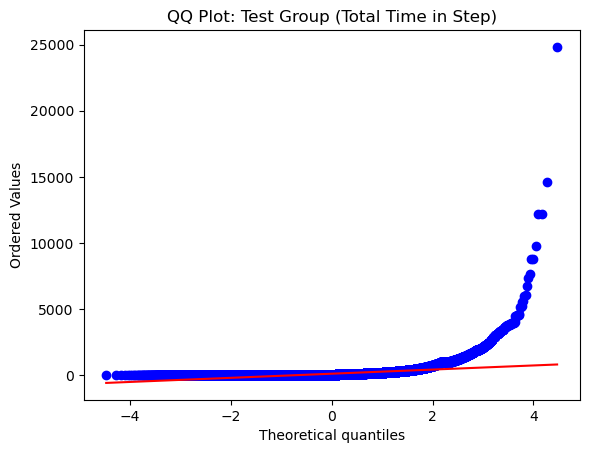

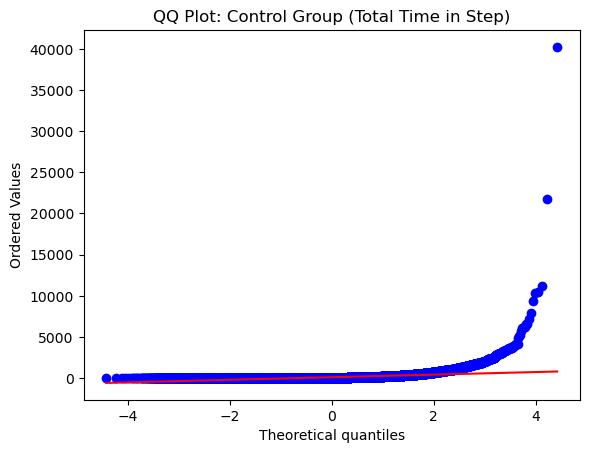

In [212]:
# QQ plot para el tiempo total en los pasos de Test
stats.probplot(df_pt[df_pt['variation'] == 'Test']['total_time_in_step'], dist="norm", plot=plt)
plt.title('QQ Plot: Test Group (Total Time in Step)')
plt.show()

# QQ plot para el tiempo total en los pasos de Control
stats.probplot(df_pt[df_pt['variation'] == 'Control']['total_time_in_step'], dist="norm", plot=plt)
plt.title('QQ Plot: Control Group (Total Time in Step)')
plt.show()

#### A/B Test

- Comparamos el rendimiento de una versión nueva (Test) y una versión antigua (Control) de una plataforma web, el A/B test tiene como objetivo principal evaluar si las diferencias entre ambas versiones son estadísticamente significativas. En este caso, "A" se refiere a la versión Control (la antigua plataforma) y "B" a la versión Test (la nueva plataforma).

- Pasos del A/B Test:

    - Formulación de la hipótesis:

        - Hipótesis nula (H0): No hay diferencias significativas entre la versión Test y Control en términos de tasas de finalización, tiempos de finalización, tasas de error, etc.
        - Hipótesis alternativa (H1): Hay una diferencia significativa entre la versión Test y Control en al menos una de las métricas.

    - Métricas a evaluar:

        - Tasa de finalización: Si los usuarios de la versión Test completan el proceso más que los de la versión Control.
        - Tasa de error: Si los usuarios en la versión Test cometen menos errores que los de Control.
        - Tiempo en cada paso: Comparar los tiempos promedio en cada paso entre los usuarios de Test y Control.
        - Linealidad del proceso: Evaluar cuántos usuarios siguen el proceso correctamente (sin errores ni repeticiones).

    - Comparación de grupos:

        - Grupo A: Usuarios en la versión Control.
        - Grupo B: Usuarios en la versión Test.

    - Pruebas estadísticas:

        - Prueba de proporciones: Para comparar las tasas de finalización entre Test y Control.
        - T-test o Mann-Whitney U test: Para comparar los tiempos medios en cada paso entre los dos grupos (Test y Control).
        - Chi-square test: Para evaluar si la distribución de errores o completaciones entre Test y Control es significativamente diferente.
        - Cramér’s V: Para medir la fuerza de asociación entre las variables categóricas, como los errores y los pasos completados correctamente en ambas versiones.

    - Resultados:

        - Analizar si las diferencias observadas en el comportamiento de los usuarios en la versión Test frente a la Control son significativas o si pueden atribuirse al azar.

    - Ejemplo de aplicación:

        - Tasa de finalización: Puedes calcular la proporción de usuarios que completan el proceso en ambos grupos y luego usar una prueba de hipótesis para ver si la diferencia es significativa.
        - Tiempo en cada paso: Si los usuarios de la versión Test pasan menos tiempo en los pasos críticos del proceso (como "step_3" o "confirm"), esto podría sugerir que la nueva versión es más eficiente.

    - Responder preguntas como:

        - ¿Es la nueva versión (Test) mejor en términos de tasa de finalización y experiencia de usuario?
        - ¿El nuevo diseño reduce los tiempos en los pasos o el número de errores?
        - ¿Qué impacto tiene la nueva versión en diferentes grupos de clientes (según edad, actividad, balance, etc.)?

#### Confirmación de si la diferencia en la tasa de finalización del nuevo diseño y el diseño anterior es estadísticamente significativa.

- Cuando hablamos de que una diferencia es "estadísticamente significativa", significa que la diferencia observada en los resultados no es producto del azar, sino que es lo suficientemente grande como para concluir que hay un efecto real o una verdadera diferencia entre los grupos comparados (en este caso, entre el grupo Test y el grupo Control).

- Si la diferencia en las tasas de finalización entre ambos grupos es lo suficientemente grande, podemos estar razonablemente seguros de que el nuevo diseño está teniendo un impacto (positivo o negativo) sobre la tasa de finalización, y no es solo una fluctuación aleatoria en los datos.

- Se evalúa usando una prueba estadística. La más común en un A/B test es la prueba de hipótesis con el cálculo de un valor p. Este proceso incluye los siguientes pasos:

    - Hipótesis nula (H₀): No hay diferencia en las tasas de finalización entre Test y Control. Cualquier diferencia es debido al azar.

    - Hipótesis alternativa (H₁): Hay una diferencia en las tasas de finalización entre Test y Control (ya sea positiva o negativa).

    - Prueba estadística: Se utiliza un test estadístico para comparar las tasas de finalización de los dos grupos. En este caso, una prueba Z para proporciones es común para A/B tests.

    - Cálculo del valor p: El valor p indica la probabilidad de que la diferencia observada entre los grupos ocurra solo por azar si la hipótesis nula fuera verdadera.

        - Si el valor p es menor que un umbral predefinido (por ejemplo, 0.05 o 5%), se rechaza la hipótesis nula y se concluye que la diferencia es estadísticamente significativa.

    - Umbral de significancia (α): Normalmente se utiliza un nivel de significancia del 5% (α = 0.05). Si el valor p es menor que este umbral, la diferencia se considera estadísticamente significativa.

- Prueba Z de proporciones:

In [215]:
from statsmodels.stats.proportion import proportions_ztest

# Tasas de finalización en Test y Control
n_test = df_pt[df_pt['variation'] == 'Test']['client_id'].nunique()  # Número de usuarios en Test
n_control = df_pt[df_pt['variation'] == 'Control']['client_id'].nunique()  # Número de usuarios en Control

completed_test = df_pt[(df_pt['variation'] == 'Test') & (df_pt['lineal'] == True)]['client_id'].nunique()  # Usuarios que completaron el proceso en Test
completed_control = df_pt[(df_pt['variation'] == 'Control') & (df_pt['lineal'] == True)]['client_id'].nunique()  # Usuarios que completaron el proceso en Control

# Proporciones
p_test = completed_test / n_test
p_control = completed_control / n_control

# Prueba Z
count = [completed_test, completed_control]
nobs = [n_test, n_control]

stat, p_value = proportions_ztest(count, nobs)

print(f"Estadístico Z: {stat}")
print(f"Valor p: {p_value}")

# Decisión
if p_value < 0.05:
    print("La diferencia en las tasas de finalización es estadísticamente significativa.")
else:
    print("La diferencia en las tasas de finalización NO es estadísticamente significativa.")

Estadístico Z: 3.1660086134803356
Valor p: 0.0015454621727767797
La diferencia en las tasas de finalización es estadísticamente significativa.


- Valor p es menor a 0.05, podemos concluir que la diferencia en la tasa de finalización entre Test y Control es estadísticamente significativa, lo que indica que el nuevo diseño tiene un efecto real (positivo o negativo).

#### Análisis para garantizar que el aumento observado en la tasa de finalización de la prueba A/B cumple o supera este umbral del 5%.

- Necesitamos comparar las tasas de finalización de los dos grupos (Test y Control) y asegurarnos de que el aumento entre ambos sea al menos del 5%.

- Pasos para realizar el análisis:

    - Calcular la tasa de finalización para ambos grupos (Test y Control), identificamos cuántos usuarios completaron el proceso correctamente:

        - Tasa de finalización = nº de usuarios que completaron el proceso / nº total de usuarios

    - Calcular la diferencia porcentual entre las tasas de finalización de los grupos, para determinar si la versión de prueba ha mejorado significativamente:

        - Diferencia porcentual = ((Tasa Test - Tasa Control) / Tasa Control ) * 100

    - Verificar si el aumento es superior al 5%.

In [213]:
# Calcular la tasa de finalización para Test y Control
completion_rate_test = df_pt[df_pt['variation'] == 'Test']['lineal'].mean()  # Tasa de finalización en Test
completion_rate_control = df_pt[df_pt['variation'] == 'Control']['lineal'].mean()  # Tasa de finalización en Control

# Calcular la diferencia porcentual entre las tasas
percentage_increase = ((completion_rate_test - completion_rate_control) / completion_rate_control) * 100

# Comparar con el umbral del 5%
if percentage_increase >= 5:
    print(f"El aumento en la tasa de finalización es del {percentage_increase:.2f}%, que supera el umbral del 5%.")
else:
    print(f"El aumento en la tasa de finalización es del {percentage_increase:.2f}%, que NO supera el umbral del 5%.")


El aumento en la tasa de finalización es del -5.08%, que NO supera el umbral del 5%.


- Resultados:

    - El resultado, un -5.08%, indica que la tasa de finalización en el grupo Test es en realidad más baja que la del grupo Control. En otras palabras, la versión de prueba (Test) tiene una tasa de finalización inferior a la versión original (Control), lo que explica el valor negativo en la diferencia porcentual.

    - Problemas en la versión Test: La versión Test de la web podría tener características que hacen que los usuarios completen menos el proceso en comparación con la versión Control.

    - Variabilidad natural: Podría haber una variabilidad natural en los resultados, dependiendo del número de usuarios y el tiempo de prueba.

    - Distribución de los usuarios: Puede ser útil verificar si ambos grupos tienen una distribución similar en términos de características como edad, género, actividad, etc., para asegurarse de que los grupos son comparables.

In [214]:
print(f"Tasa de finalización en Test: {completion_rate_test:.2%}")
print(f"Tasa de finalización en Control: {completion_rate_control:.2%}")

Tasa de finalización en Test: 37.61%
Tasa de finalización en Control: 39.63%


- Revisar si hay algún paso específico en el flujo de la versión Test que tenga una mayor tasa de error o abandono en comparación con la versión Control.
- Revisar la tasa de finalización por diferentes subgrupos, como por edad, género, o nivel de actividad, para ver si hay diferencias significativas dentro de ciertos segmentos.

#### T-test para comparar los tiempos medios de finalización entre Test y Control

- El T-test para muestras independientes es una opción adecuada para comparar las medias de dos grupos (Test vs Control) y determinar si las diferencias en los tiempos de finalización son estadísticamente significativas.

- Hipótesis:

    - Hipótesis nula (H₀): No hay diferencia significativa en el tiempo promedio de finalización entre la versión Test y la versión Control.

    - Hipótesis alternativa (H₁): Hay una diferencia significativa en el tiempo promedio de finalización entre la versión Test y la versión Control.

- Se realiza un T-test para muestras independientes. El argumento equal_var=False se usa porque las varianzas entre los dos grupos pueden no ser iguales.

- El estadístico t y el valor p te indicarán si existe una diferencia significativa entre los tiempos promedio de finalización en Test y Control.

In [216]:
# Filtrar los tiempos de finalización para Test y Control (asumiendo que 'total_time_in_step' es el tiempo total en segundos)
time_test = df_pt[(df_pt['variation'] == 'Test') & (df_pt['step'] == 'confirm')]['total_time_in_step']
time_control = df_pt[(df_pt['variation'] == 'Control') & (df_pt['step'] == 'confirm')]['total_time_in_step']

# Realizar el T-test para comparar las medias
t_stat, p_value = stats.ttest_ind(time_test, time_control, equal_var=False)

print(f"Estadístico t: {t_stat}")
print(f"Valor p: {p_value}")

# Decisión
if p_value < 0.05:
    print("La diferencia en los tiempos de finalización es estadísticamente significativa.")
else:
    print("La diferencia en los tiempos de finalización NO es estadísticamente significativa.")

Estadístico t: -17.146843890648363
Valor p: 1.1452111134482975e-65
La diferencia en los tiempos de finalización es estadísticamente significativa.


- p es menor a 0.05, se rechaza la hipótesis nula y puedes concluir que hay una diferencia significativa en los tiempos de finalización entre Test y Control.

#### T-test para comparar los tiempos medios de finalización entre Test y Control segmentado por lineal

- Combinamos la prueba de hipótesis de los tiempos de finalización entre la versión Test y Control con la variable lineal (que indica si el usuario siguió el proceso de manera correcta o no)

In [218]:
from scipy import stats

# Filtrar los datos para usuarios lineales y no lineales en Test y Control
time_test_lineal = df_pt[(df_pt['variation'] == 'Test') & (df_pt['lineal'] == True) & (df_pt['step'] == 'confirm')]['total_time_in_step']
time_control_lineal = df_pt[(df_pt['variation'] == 'Control') & (df_pt['lineal'] == True) & (df_pt['step'] == 'confirm')]['total_time_in_step']

time_test_non_lineal = df_pt[(df_pt['variation'] == 'Test') & (df_pt['lineal'] == False) & (df_pt['step'] == 'confirm')]['total_time_in_step']
time_control_non_lineal = df_pt[(df_pt['variation'] == 'Control') & (df_pt['lineal'] == False) & (df_pt['step'] == 'confirm')]['total_time_in_step']

# Realizar el T-test para los usuarios lineales
t_stat_lineal, p_value_lineal = stats.ttest_ind(time_test_lineal, time_control_lineal, equal_var=False)

# Realizar el T-test para los usuarios no lineales
t_stat_non_lineal, p_value_non_lineal = stats.ttest_ind(time_test_non_lineal, time_control_non_lineal, equal_var=False)

# Resultados para usuarios lineales
print("Resultados para usuarios lineales:")
print(f"Estadístico t: {t_stat_lineal}")
print(f"Valor p: {p_value_lineal}")

if p_value_lineal < 0.05:
    print("La diferencia en los tiempos de finalización es estadísticamente significativa para usuarios lineales.")
else:
    print("La diferencia en los tiempos de finalización NO es estadísticamente significativa para usuarios lineales.")

# Resultados para usuarios no lineales
print("\nResultados para usuarios no lineales:")
print(f"Estadístico t: {t_stat_non_lineal}")
print(f"Valor p: {p_value_non_lineal}")

if p_value_non_lineal < 0.05:
    print("La diferencia en los tiempos de finalización es estadísticamente significativa para usuarios no lineales.")
else:
    print("La diferencia en los tiempos de finalización NO es estadísticamente significativa para usuarios no lineales.")

Resultados para usuarios lineales:
Estadístico t: -13.329832250819301
Valor p: 2.183596584825488e-40
La diferencia en los tiempos de finalización es estadísticamente significativa para usuarios lineales.

Resultados para usuarios no lineales:
Estadístico t: -9.37222108044775
Valor p: 8.111545008015922e-21
La diferencia en los tiempos de finalización es estadísticamente significativa para usuarios no lineales.


#### Evaluación del experimento respondiendo preguntas relacionadas con:

#### Eficacia del diseño

- La eficacia del diseño se refiere a qué tan bien el nuevo diseño de la web (grupo Test) mejora la experiencia del usuario en comparación con el diseño anterior (grupo Control). Para evaluar esto, consideramos varias métricas clave:

    - Tasa de Finalización:

        - La tasa de finalización compara cuántos usuarios completaron exitosamente el proceso. Si la tasa de finalización en el grupo Test es mayor que en Control, el nuevo diseño sería más eficaz.
        - Evaluar si las diferencias en la tasa de finalización son estadísticamente significativas también es crucial, lo que ya hemos hecho con el T-test y podemos corroborar con los valores p.

    - Tiempos en los pasos:

        - El análisis de los tiempos de cada paso para ambos grupos permite ver si los usuarios del grupo Test completan el proceso más rápido que los del grupo Control.
        - Podemos analizar el tiempo total empleado en cada paso y en general para asegurarte de que el nuevo diseño sea más eficiente.

    - Errores:

        - Comparar las tasas de error entre el grupo Test y Control es importante para ver si el nuevo diseño está generando más o menos errores (usuarios que no completan el proceso de manera lineal).

    - Preguntas a considerar para la eficacia:

        - ¿El nuevo diseño (Test) tiene una tasa de finalización mayor que el diseño anterior (Control)?
        - ¿Es más rápido el proceso en el nuevo diseño?
        - ¿Genera menos errores el nuevo diseño?

- Si las respuestas son afirmativas (y estadísticamente significativas), podemos concluir que el diseño es más eficaz.

#### Duración del experimento

- La duración de un experimento A/B es crucial para obtener resultados estadísticamente confiables. Necesitamos asegurar que la cantidad de usuarios y el tiempo de prueba son suficientes para que las diferencias observadas no se deban al azar. Para esto, consideramos:

    - Tamaño de la muestra:

        - ¿Cuántos usuarios participaron en el experimento? Si el tamaño de la muestra es pequeño, los resultados pueden no ser representativos.
        - Podemos realizar un cálculo de poder estadístico para asegurar que hemos recolectado suficientes datos.

    - Duración del experimento:

        - Si los tiempos de interacción varían a lo largo del tiempo (debido a eventos estacionales, cambios en el tráfico, etc.), podríamos necesitar más tiempo para asegurar que los resultados sean estables y representativos.

    - Preguntas a considerar para la duración:

        - ¿Cuántos usuarios han participado en el experimento? ¿Es suficiente para obtener resultados significativos?
        - ¿Se realizó el experimento por un tiempo lo suficientemente largo como para capturar patrones de comportamiento típicos de los usuarios?
        - Si el experimento fue demasiado corto o con pocos usuarios, podría ser necesario extenderlo para obtener resultados más confiables.

In [219]:
# Contar cuántos usuarios únicos participaron en Test y Control
usuarios_test = df_pt[df_pt['variation'] == 'Test']['client_id'].nunique()
usuarios_control = df_pt[df_pt['variation'] == 'Control']['client_id'].nunique()

print(f"Usuarios en Test: {usuarios_test}")
print(f"Usuarios en Control: {usuarios_control}")

Usuarios en Test: 26961
Usuarios en Control: 23526


In [220]:
# Verificar el rango de fechas para Test y Control
rango_test = df_pt[df_pt['variation'] == 'Test']['date_time'].agg([min, max])
rango_control = df_pt[df_pt['variation'] == 'Control']['date_time'].agg([min, max])

print(f"Duración del experimento en Test: {rango_test['min']} to {rango_test['max']}")
print(f"Duración del experimento en Control: {rango_control['min']} to {rango_control['max']}")

C:\Users\usr\AppData\Local\Temp\ipykernel_3712\200404598.py:2: FutureWarning: The provided callable <built-in function min> is currently using Series.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  rango_test = df_pt[df_pt['variation'] == 'Test']['date_time'].agg([min, max])
C:\Users\usr\AppData\Local\Temp\ipykernel_3712\200404598.py:2: FutureWarning: The provided callable <built-in function max> is currently using Series.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  rango_test = df_pt[df_pt['variation'] == 'Test']['date_time'].agg([min, max])
C:\Users\usr\AppData\Local\Temp\ipykernel_3712\200404598.py:3: FutureWarning: The provided callable <built-in function min> is currently using Series.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the s

Duración del experimento en Test: 2017-03-15 00:43:23 to 2017-06-20 23:21:23
Duración del experimento en Control: 2017-03-15 00:19:28 to 2017-06-20 23:57:06


#### Necesidades de Datos Adicionales

- A veces, los datos recolectados no son suficientes para explicar completamente el comportamiento de los usuarios, o para abordar ciertas preguntas clave. Podríamos necesitar datos adicionales en función de:

    - Segmentación adicional:
        
        - Podríamos necesitar datos demográficos más específicos, como el dispositivo utilizado (móvil vs. desktop), región geográfica, historial de uso de la web, etc., para entender si ciertos segmentos de usuarios tienen experiencias muy diferentes en el nuevo diseño.

    - Más eventos de interacción:
        
        - Si no se han capturado todos los eventos de interacción (clics, scroll, abandono), podríamos agregar más puntos de datos para tener una vista completa del comportamiento del usuario.

    - Preguntas a considerar sobre datos adicionales:

        - ¿Hay algún segmento de usuarios que parece comportarse de manera diferente pero no hemos recolectado datos suficientes sobre ellos?
        - ¿Sería útil agregar datos sobre dispositivos, ubicaciones geográficas o historial de interacciones para analizar mejor las diferencias entre Test y Control?